# <a id='toc1_'></a>[TME 8 - Détection et explication d'exceptions](#toc0_)


![](https://media.discordapp.net/attachments/1047111061314220033/1176542563633737728/image.png)


_Notes :_

- Approche contre factuelle $\Rightarrow$ que faire pour que l'exemple ne soit plus un outlier ?
- Base de référence : dataset classique


**Table of contents**<a id='toc0_'></a>    
- [TME 8 - Détection et explication d'exceptions](#toc1_)    
  - [Génération d'une base artificielle](#toc1_1_)    
  - [Détection d'exceptions](#toc1_2_)    
    - [Outlier detection](#toc1_2_1_)    
    - [Novelty detection](#toc1_2_2_)    
    - [Importance des hyper-paramètres pour le One-Class SVM](#toc1_2_3_)    
  - [Explications naïves](#toc1_3_)    
    - [Growing Spheres](#toc1_3_1_)    
      - [LOF - Explications contrefactuelles](#toc1_3_1_1_)    
        - [3 clusters (distributions normales multidimensionnelles)](#toc1_3_1_1_1_)    
        - [2 clusters (distributions normales multidimensionnelles)](#toc1_3_1_1_2_)    
      - [1 cluster (blob)](#toc1_3_1_2_)    
      - [One-Class SVM - Explications contrefactuelles](#toc1_3_1_3_)    
      - [Isolation Forest - Explications contrefactuelles](#toc1_3_1_4_)    
    - [Importance d'attribut](#toc1_3_2_)    
  - [Explications moins naïves](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Génération d'une base artificielle](#toc0_)


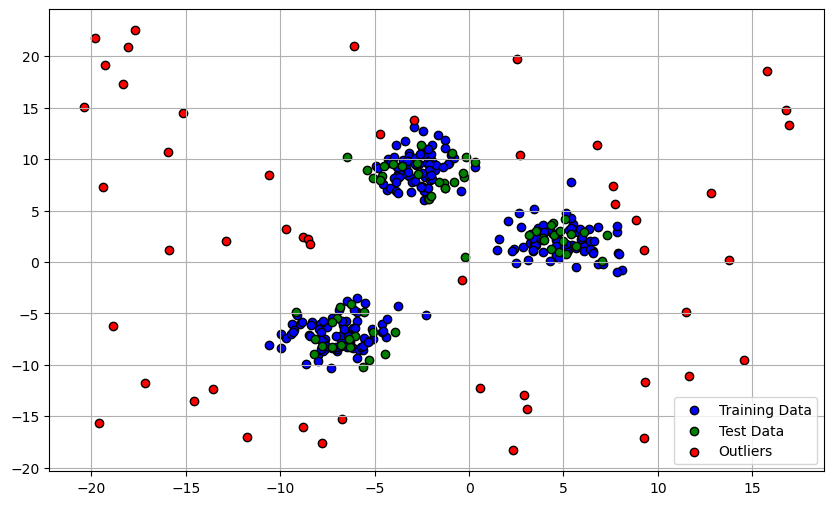

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# %matplotlib widget


def generate_blobs(
    n_samples=500,
    n_clusters=3,
    cluster_std=1.0,
    n_outliers=50,
    random_seed=42,
):
    """Génère des données artificielles de type "blobs".

    :param n_samples: Nombre d'échantillons, 500 par défaut.
    :param n_clusters: Nombre de clusters, 3 par défaut.
    :param cluster_std: Ecart-type des clusters, 1.0 par défaut.
    :param n_outliers: Nombre d'outliers, 50 par défaut.
    :param random_seed: Graine aléatoire, 42 par défaut.
    :return: Un ensemble de train, de test et d'outliers.
    """
    rng = np.random.RandomState(random_seed)

    X, _, centers = make_blobs(
        n_samples=n_samples,
        n_features=2,
        centers=n_clusters,
        cluster_std=cluster_std,
        random_state=random_seed,
        return_centers=True,
    )

    X_outliers = generate_outliers(
        X, centers, n_outliers=n_outliers, random_seed=random_seed
    )

    # Séparer les données en ensembles d'entraînement et de test
    rng.shuffle(X)
    n_train = int(0.8 * len(X))
    X_train = X[:n_train]
    X_test = X[n_train:]

    return X_train, X_test, X_outliers


def generate_outliers(X, centers, n_outliers=50, min_distance=4, random_seed=42):
    """Génère des outliers, c'est-à-dire des points qui sont en dehors des clusters
    générés. Le plus simple serait de générer aléatoirement des outliers sur l'ensemble
    de la grille, mais cela résulterait en des outliers faisant potentiellement partie
    de clusters, biaisant alors notre détection.

    :param X: Clusters.
    :param centers: Centres des clusters.
    :param n_outliers: Nombre d'outliers, defaults to 50
    :param min_distance: Distance euclidienneminimale entre les clusters et les outliers,
    4 est une bonne valeur minimisant le nombre d'outliers pouvant apparaître dans les
    clusters tout en leur laissant la possibilité d'être proche.
    :param random_seed: Graine aléatoire pour la reproductibilité.
    :return: Un ensemble d'outliers.
    """
    rng = np.random.RandomState(random_seed)
    # Générer des outliers
    X_outliers = []
    while len(X_outliers) < n_outliers:
        outlier_candidate = rng.uniform(
            X.min(axis=0) - 10.0, X.max(axis=0) + 10.0, X.shape[1]
        )
        # Est-ce que le candidat est un outlier, c.-à-d. ne fait-il pas partie d'un cluster ?
        if np.all(
            np.min(np.linalg.norm(centers - outlier_candidate, axis=1)) >= min_distance
        ):
            X_outliers.append(outlier_candidate)
    return np.array(X_outliers)


def plot_data(X_train, X_test, X_outliers):
    """Affiche les données artificiellement générées."""
    plt.figure(figsize=(10, 6))
    # Plot les données d'entraînement
    plt.scatter(
        X_train[:, 0], X_train[:, 1], c="blue", label="Training Data", edgecolors="k"
    )
    # Plot les données de test
    plt.scatter(
        X_test[:, 0], X_test[:, 1], c="green", label="Test Data", edgecolors="k"
    )
    # Plot les outliers
    plt.scatter(
        X_outliers[:, 0], X_outliers[:, 1], c="red", label="Outliers", edgecolors="k"
    )
    plt.legend()
    plt.grid(True)
    plt.show()


X_train, X_test, X_outliers = generate_blobs(
    n_samples=300, n_clusters=3, cluster_std=1.5, n_outliers=50
)
plot_data(X_train, X_test, X_outliers)

## <a id='toc1_2_'></a>[Détection d'exceptions](#toc0_)

Avec Scikit-learn, il existe deux méthodes possibles :

- **Outlier detection** : approche supervisée, les données contiennent les outliers.
- **Novelty detection** : approche non supervisée, les données ne contiennent pas les outliers. L'algorithme apprend où *seraient* les outliers. 

La différence majeure concerne le LOF, qui a été désigné spécifiquement pour de l'outlier detection. Dans ce mode de détection, LOF ne contient qu'une méthode `fit_predict` : il est **impossible** d'obtenir les frontières de décision. On peut seulement obtenir les scores : plus le score est grand, plus l'observation est un outlier.

Pour le One-Class SVM et la forêt d'isolation, la construction du classifieur ne change pas.


In [2]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest


def train_lof(X_train, mode, n_neighbors=20, contamination="auto"):
    """Entraine un Local Outlier Factor.

    Outlier detection si mode=False, novelty detection si mode=True.
    """
    clf = LocalOutlierFactor(
        n_neighbors=n_neighbors, novelty=mode, contamination=contamination
    )
    if mode:
        clf.fit(X_train)
    return clf


def train_one_class_svm(X_train, nu=0.5, gamma="auto"):
    """Entraine un One-Class SVM."""
    clf = OneClassSVM(kernel="rbf", gamma=gamma, nu=nu)
    clf.fit(X_train)
    return clf


def train_isolation_forest(
    X_train, n_estimators=100, max_samples="auto", contamination="auto", random_state=0
):
    """Entraine une forêt d'isolation."""
    clf = IsolationForest(
        n_estimators=n_estimators,
        max_samples=max_samples,
        contamination=contamination,
        random_state=random_state,
    )
    clf.fit(X_train)
    return clf

### <a id='toc1_2_1_'></a>[Outlier detection](#toc0_)


In [3]:
from matplotlib.legend_handler import HandlerPathCollection


def update_legend_marker_size(handle, orig):
    "Customize size of the legend marker"
    handle.update_from(orig)
    handle.set_sizes([20])


def plot_decision_boundary_outlier(clf, X, X_outliers, ax=None, title=None):
    """Affiche les frontières de décision pour OneClassSVM, IsolationForest, le score
    des outliers pour LOF.
    """
    if not ax:
        fig, ax = plt.subplots(figsize=(10, 6))

    # Create grid to plot decision boundaries
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    mesh_samples = np.c_[xx.ravel(), yy.ravel()]

    if clf.__class__.__name__ == "LocalOutlierFactor":
        y_pred = clf.fit_predict(X)
        Z = clf.negative_outlier_factor_
        radius = (Z.max() - Z) / (Z.max() - Z.min())
        scatter = ax.scatter(
            X[:, 0],
            X[:, 1],
            s=1000 * radius,
            edgecolor="firebrick",
            facecolors="none",
            label="Outliers scores",
        )
    else:
        y_pred = clf.predict(X)
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(mesh_samples)
        else:
            Z = clf.predict(mesh_samples)

        Z = Z.reshape(xx.shape)
        contour = ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
        ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")
        cbar = plt.colorbar(contour, ax=ax)
        cbar.set_label("Decision Function Value")

    # Plot training points
    ax.scatter(X[:, 0], X[:, 1], c="blueviolet", edgecolor="k", s=20, label="Obs.")

    # Plot outliers
    ax.scatter(
        X_outliers[:, 0],
        X_outliers[:, 1],
        c="r",
        edgecolor="k",
        s=20,
        label="Outlier",
    )

    if title:
        ax.set_title(title)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    if clf.__class__.__name__ == "LocalOutlierFactor":
        ax.legend(
            fontsize="small",
            handler_map={
                scatter: HandlerPathCollection(update_func=update_legend_marker_size)
            },
        )
    else:
        ax.legend(fontsize="small")

    # Statistics
    ground_truth = np.ones(len(X), dtype=int)
    ground_truth[-len(X_outliers) :] = -1
    n_errors = (y_pred != ground_truth).sum()
    ax.set_xlabel(f"errors: {n_errors}/{X.shape[0]}")

    return ax

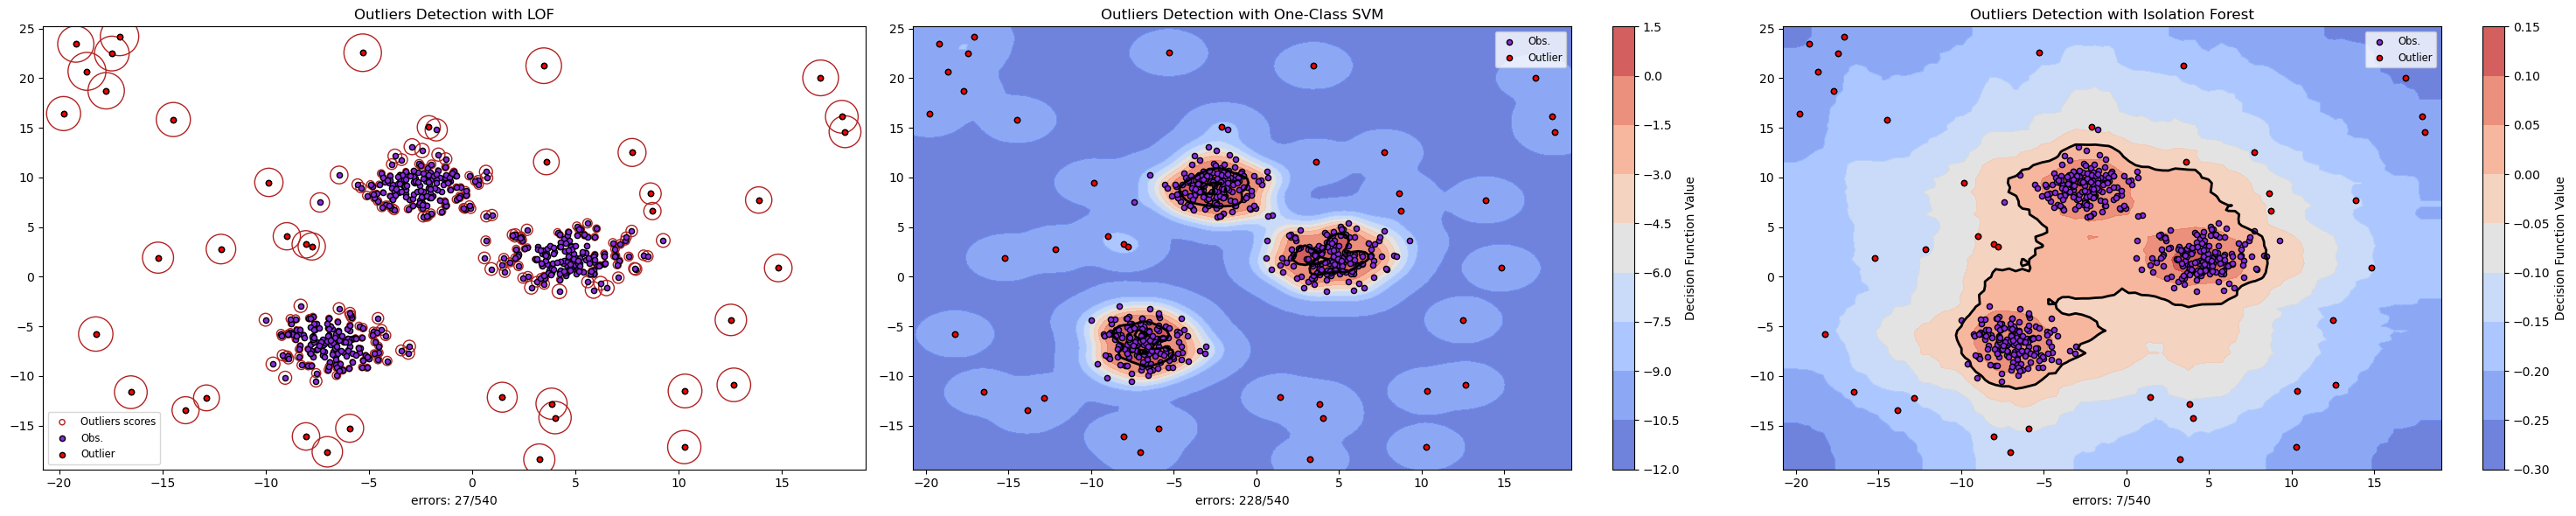

In [4]:
# Generate data
X_train, X_test, X_outliers = generate_blobs(
    n_samples=500, n_clusters=3, cluster_std=1.5, n_outliers=40
)
X = np.vstack((X_train, X_test, X_outliers))
# Entraîner chaque modèle
lof_clf = train_lof(X, mode=False)
svm_clf = train_one_class_svm(X)
iso_forest_clf = train_isolation_forest(X)

# Visualize decision boundaries for each model
fig, ax = plt.subplots(1, 3, figsize=(30, 6))

plot_decision_boundary_outlier(
    lof_clf, X, X_outliers, ax=ax[0], title="Outliers Detection with LOF"
)
plot_decision_boundary_outlier(
    svm_clf, X, X_outliers, ax=ax[1], title="Outliers Detection with One-Class SVM"
)
plot_decision_boundary_outlier(
    iso_forest_clf,
    X,
    X_outliers,
    ax=ax[2],
    title="Outliers Detection with Isolation Forest",
)
fig.tight_layout()

### <a id='toc1_2_2_'></a>[Novelty detection](#toc0_)


In [5]:
def plot_decision_boundary_novelty(
    clf, X_train, X_test, X_outliers, explain=False, ax=None, title=None
):
    """Affiche les frontières de décision d'un classifieur."""
    if not ax:
        fig, ax = plt.subplots(figsize=(10, 6))

    # Create grid to plot decision boundaries
    x_min, x_max = (
        min(X_train[:, 0].min(), X_outliers[:, 0].min()) - 1,
        max(X_train[:, 0].max(), X_outliers[:, 0].max()) + 1,
    )
    y_min, y_max = (
        min(X_train[:, 1].min(), X_outliers[:, 1].min()) - 1,
        max(X_train[:, 1].max(), X_outliers[:, 1].max()) + 1,
    )
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    mesh_samples = np.c_[xx.ravel(), yy.ravel()]

    # Plot decision boundary
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(mesh_samples)
    else:
        Z = clf.predict(mesh_samples)
    Z = Z.reshape(xx.shape)
    contour = ax.contourf(xx, yy, Z, levels=10, cmap=plt.cm.cividis, alpha=0.8)
    ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors="red")
    # Add a colorbar
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label("Decision Function Value")

    # Plot training points
    ax.scatter(
        X_train[:, 0],
        X_train[:, 1],
        c="white",
        edgecolor="k",
        s=20,
        label="Training obs.",
    )

    if explain:
        color = "white"
        label = None
    else:
        color = "blueviolet"
        label = "New regular obs."
    # Plot test points
    ax.scatter(
        X_test[:, 0],
        X_test[:, 1],
        c=color,
        edgecolor="k",
        s=20,
        label=label,
    )
    # Plot outliers
    ax.scatter(
        X_outliers[:, 0],
        X_outliers[:, 1],
        c="red",
        edgecolor="k",
        s=20,
        label="New abnormal obs.",
    )

    if title:
        ax.set_title(title)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.legend(fontsize="small")

    # Statistics
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    y_pred_outliers = clf.predict(X_outliers)
    n_error_train = y_pred_train[y_pred_train == -1].size
    n_error_test = y_pred_test[y_pred_test == -1].size
    n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size
    ax.set_xlabel(
        "error train: %d/%d; errors novel regular: %d/%d; errors novel abnormal: %d/%d"
        % (
            n_error_train,
            X_train.shape[0],
            n_error_test,
            X_test.shape[0],
            n_error_outliers,
            X_outliers.shape[0],
        )
    )

    return ax

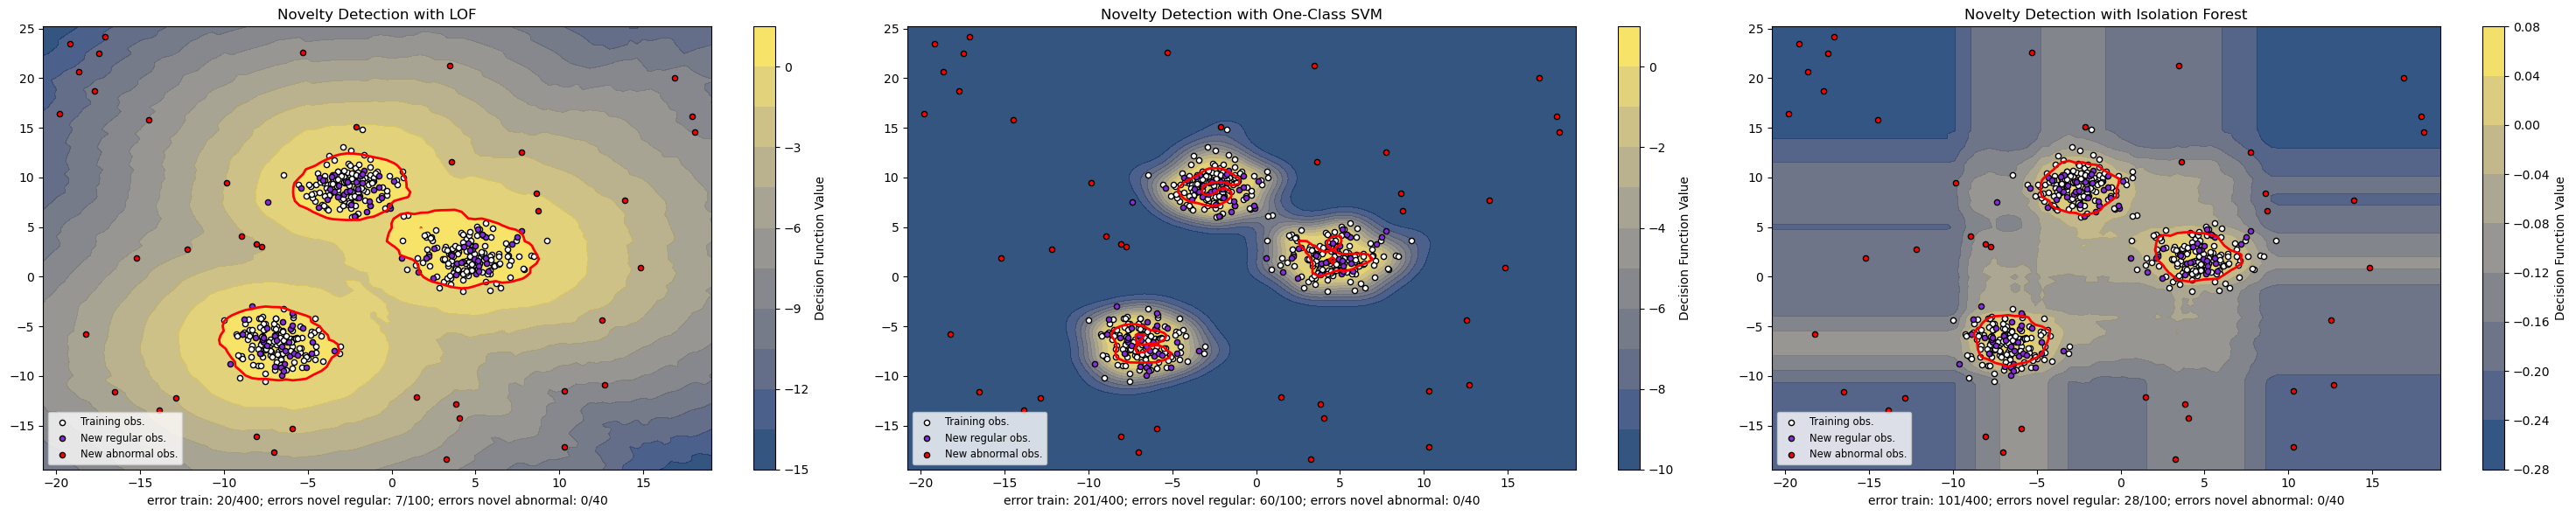

In [6]:
# Generate data
X_train, X_test, X_outliers = generate_blobs(
    n_samples=500, n_clusters=3, cluster_std=1.5, n_outliers=40
)

# Entraîner chaque modèle
lof_clf = train_lof(X_train, mode=True)
svm_clf = train_one_class_svm(X_train)
iso_forest_clf = train_isolation_forest(X_train)

# Visualize decision boundaries for each model
fig, ax = plt.subplots(1, 3, figsize=(30, 6))

plot_decision_boundary_novelty(
    lof_clf, X_train, X_test, X_outliers, ax=ax[0], title="Novelty Detection with LOF"
)
plot_decision_boundary_novelty(
    svm_clf,
    X_train,
    X_test,
    X_outliers,
    ax=ax[1],
    title="Novelty Detection with One-Class SVM",
)
plot_decision_boundary_novelty(
    iso_forest_clf,
    X_train,
    X_test,
    X_outliers,
    ax=ax[2],
    title="Novelty Detection with Isolation Forest",
)
fig.tight_layout()

J'aimerais bien avoir des données plus "allongées", comme dans le cours.

$\Rightarrow$ Loi normale multidimensionnelle : $\mathcal{N}(\mu, \Sigma)$ où $\mu \in \mathbb{R}^N$ représente le centre et $\Sigma \in \mathcal{M}_N(\mathbb{R})$ est sa matrice de covariance, $N$ étant la dimension de nos données (2 car nous travaillons en 2D).


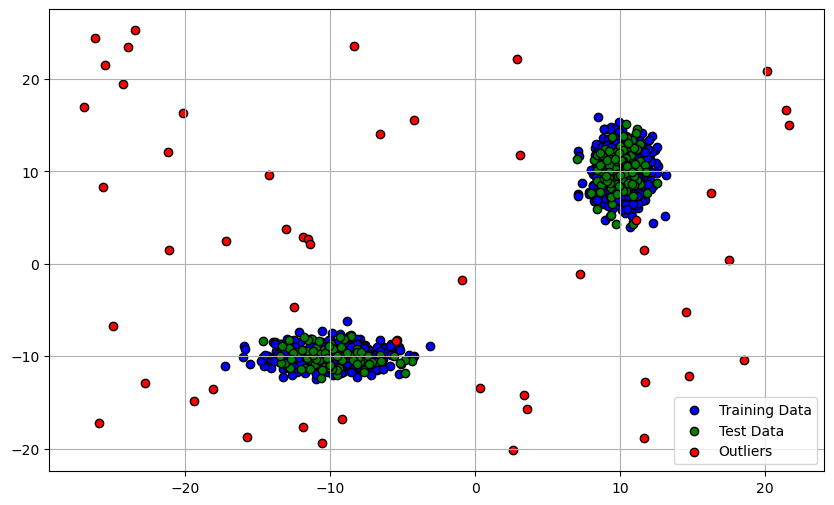

In [7]:
def generate_elongated(
    n_samples=1000,
    n_clusters=2,
    centers=[(-10, -10), (10, 10)],
    cov=[np.array([[5, 0], [0, 1]]), np.array([[1, 0], [0, 5]])],
    n_outliers=50,
    random_seed=42,
):
    """Génère des données artificielles "allongées", c.à-d. des distributions
    normales multidimensionnelles.

    :param n_samples: Nombre d'échantillons, 1000 par défaut.
    :param n_clusters: Nombre de clusters, 2 par défaut.
    :param centers: Les centres pour chaque cluster.
    :param cov: Les matrices de covariance pour chaque cluster.
    :param n_outliers: Nombre d'outliers, 50 par défaut.
    :param random_seed: Graine aléatoire, 42 par défaut.
    :return: Un ensemble de train, de test et d'outliers.
    """
    assert len(centers) == n_clusters, ValueError(
        f"Number of centers {len(centers)} must match number of clusters {n_clusters}"
    )
    assert len(cov) == n_clusters, ValueError(
        f"Number of covariance matrixes {len(centers)} must match number of clusters {n_clusters}"
    )

    rng = np.random.RandomState(random_seed)

    # Génération de distributions normales multidimensionnelles
    X = np.empty((0, 2))

    for cluster in range(n_clusters):
        X_cluster = rng.multivariate_normal(
            centers[cluster], cov[cluster], n_samples // n_clusters
        )
        X = np.vstack([X, X_cluster])

    # Générer des outliers
    X_outliers = generate_outliers(
        X, centers, n_outliers=n_outliers, random_seed=random_seed
    )

    # Séparer les données en ensembles d'entraînement et de test
    rng.shuffle(X)
    n_train = int(0.8 * len(X))
    X_train = X[:n_train]
    X_test = X[n_train:]

    return X_train, X_test, X_outliers


X_train, X_test, X_outliers = generate_elongated()
plot_data(X_train, X_test, X_outliers)

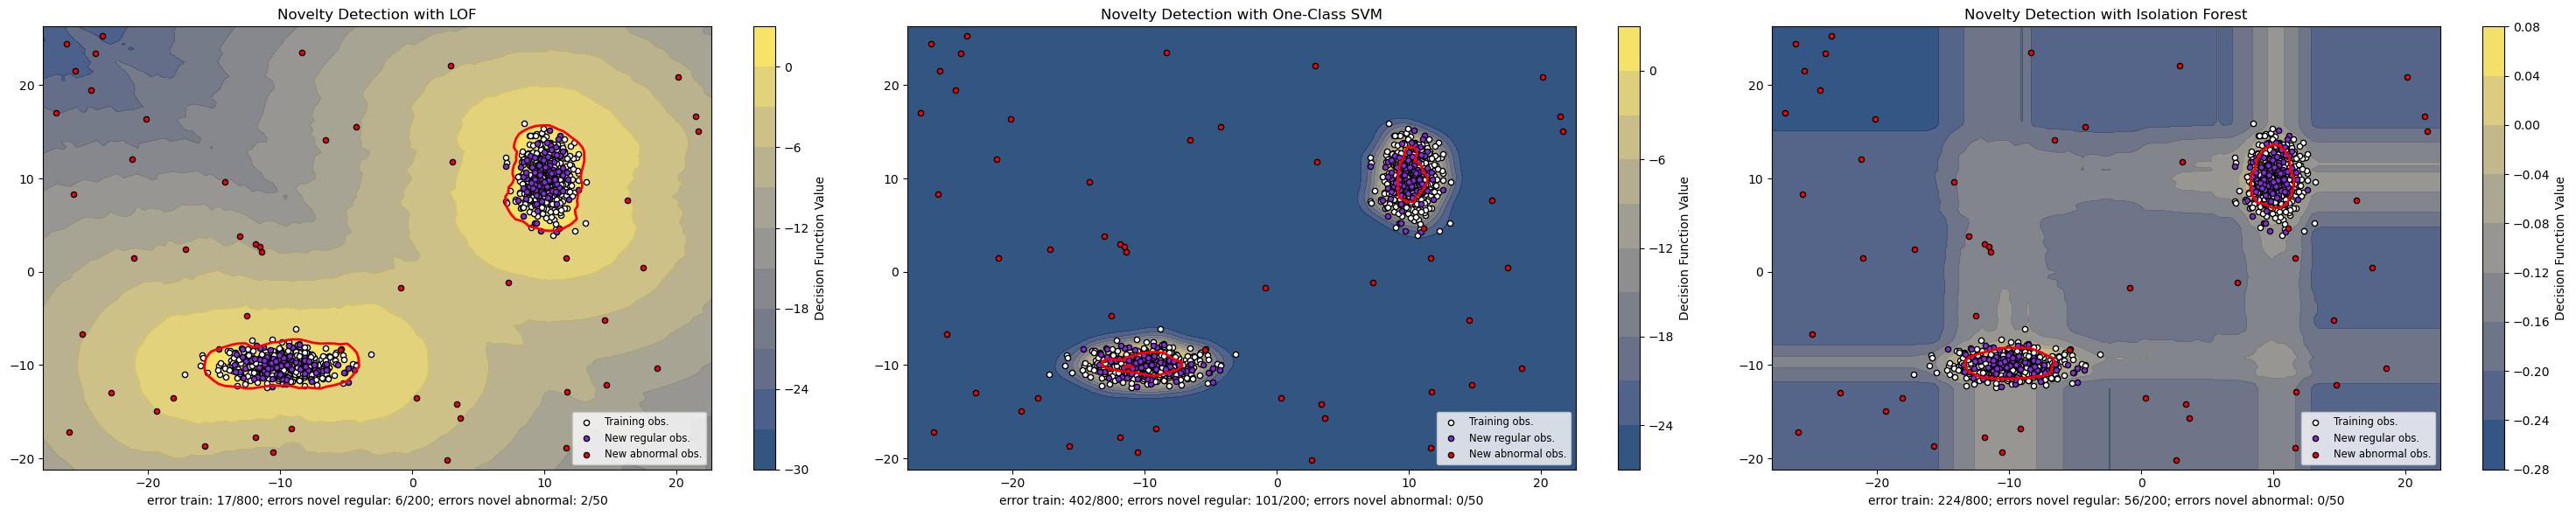

In [8]:
# Entraîner chaque modèle
lof_clf = train_lof(X_train, mode=True)
svm_clf = train_one_class_svm(X_train)
iso_forest_clf = train_isolation_forest(X_train)

# Visualize decision boundaries for each model
fig, ax = plt.subplots(1, 3, figsize=(30, 6))

plot_decision_boundary_novelty(
    lof_clf, X_train, X_test, X_outliers, ax=ax[0], title="Novelty Detection with LOF"
)
plot_decision_boundary_novelty(
    svm_clf,
    X_train,
    X_test,
    X_outliers,
    ax=ax[1],
    title="Novelty Detection with One-Class SVM",
)
plot_decision_boundary_novelty(
    iso_forest_clf,
    X_train,
    X_test,
    X_outliers,
    ax=ax[2],
    title="Novelty Detection with Isolation Forest",
)
fig.tight_layout()

Très content.

$\Rightarrow$ Combiner blobs et distributions normales multidimensionnelles ??


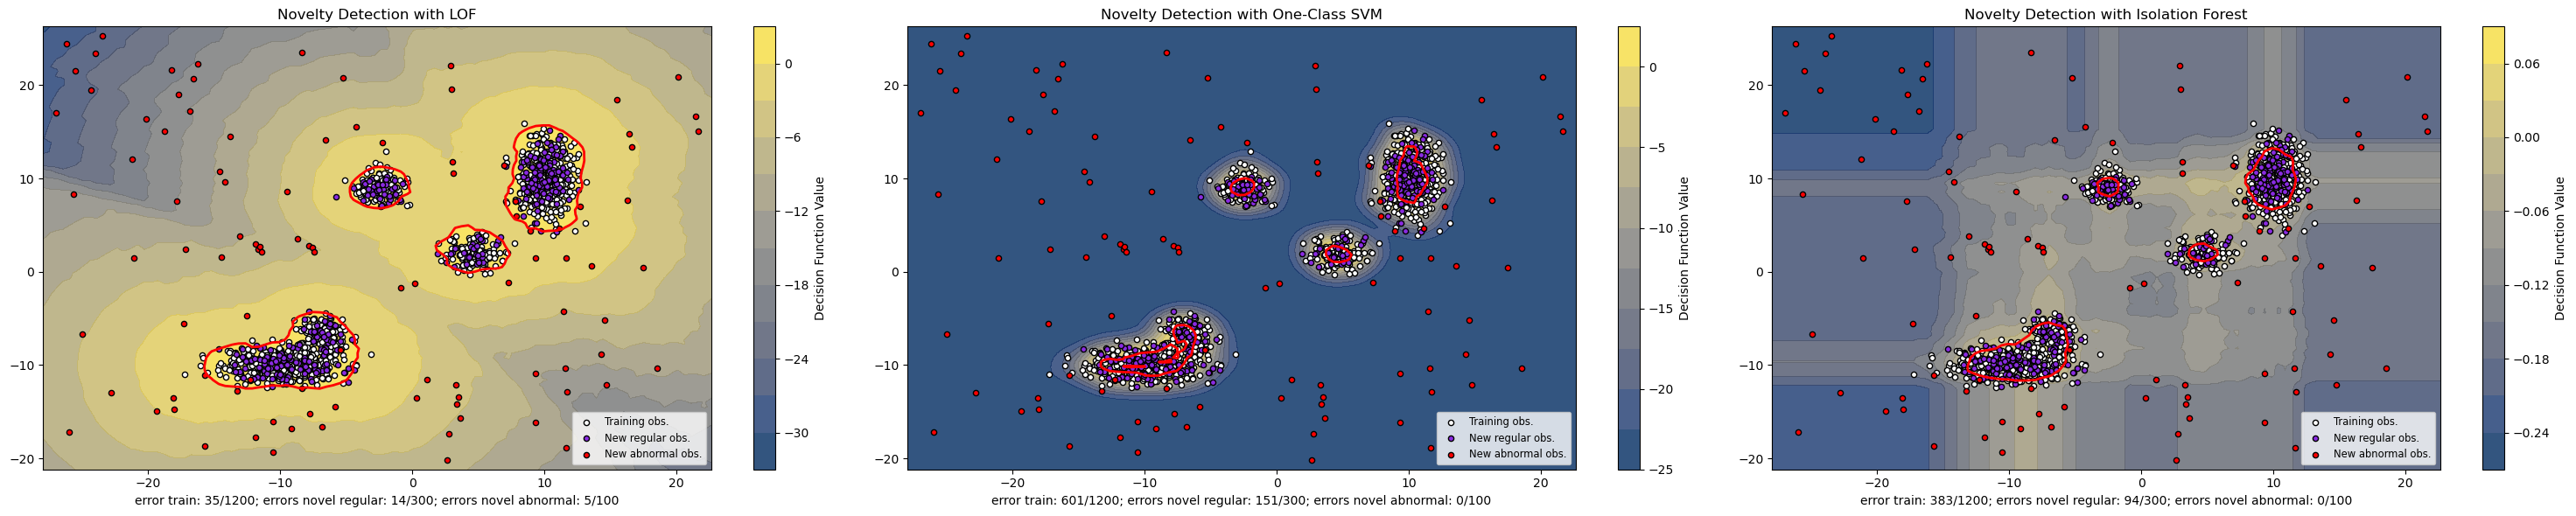

In [9]:
X_blobs_train, X_blobs_test, X_blobs_outliers = generate_blobs()
X_elongated_train, X_elongated_test, X_elongated_outliers = generate_elongated()

X_train = np.vstack((X_blobs_train, X_elongated_train))
X_test = np.vstack((X_blobs_test, X_elongated_test))
X_outliers = np.vstack((X_blobs_outliers, X_elongated_outliers))

# Entraîner chaque modèle
lof_clf = train_lof(X_train, mode=True)
svm_clf = train_one_class_svm(X_train)
iso_forest_clf = train_isolation_forest(X_train)

# Visualize decision boundaries for each model
fig, ax = plt.subplots(1, 3, figsize=(30, 6))

plot_decision_boundary_novelty(
    lof_clf, X_train, X_test, X_outliers, ax=ax[0], title="Novelty Detection with LOF"
)
plot_decision_boundary_novelty(
    svm_clf,
    X_train,
    X_test,
    X_outliers,
    ax=ax[1],
    title="Novelty Detection with One-Class SVM",
)
plot_decision_boundary_novelty(
    iso_forest_clf,
    X_train,
    X_test,
    X_outliers,
    ax=ax[2],
    title="Novelty Detection with Isolation Forest",
)
fig.tight_layout()

Bref, ça marche bien, on peut générer des données plus ou moins complexes maintenant. :)

Néanmois, toutes ces expérimentaitons sur nos différents types de données artificielles nous renvoient des _insights_ intéressants :

- **LOF :** Les frontières de décision est **ajustée autour du noyau des clusters**, qui est caractéristique du LOF (sensible à la densité locale des points de données). Il identifie les valeurs aberrantes comme des points dont la densité est nettement inférieure à celle de leurs voisins. LOF est assez précis dans l'identification des régions denses des données, mais il peut avoir des difficultés avec les points de données qui se trouvent dans les régions peu denses entre les clusters. Néanmoins, c'est **celui qui performe le mieux**.

- **One-Class SVM :** Les frontières de décision sont plus lisses (car noyau RBF) et englobent les clusters. Ce modèle tend à créer une frontière qui tente de conserver les points de données normaux tout en excluant les valeurs aberrantes. Le graphique montre une frontière **étroite autour des clusters**, mais aussi plusieurs petites limites circulaires. On observe une augmentation notable du nombre d'erreurs, tant pour les observations régulières d'entraînement que pour les nouvelles observations, ce qui signifie que la limite est trop restrictive. C'est **celui qui performe le moins**.

- **Forêt d'isolation :** Les frontières de décision sont **irrégulières**, caractéristique des arbres de décision qui cherche à isoler les exceptions. Le graphique suggère que la forêt d'isolation est moins influencée par la distribution sous-jacente des données que par leur structure. Elle effectue un partitionnement qui peut aboutir à des régions de valeurs aberrantes plus grandes, ce qui peut être bénéfique pour les ensembles de données présentant des structures complexes.


### <a id='toc1_2_3_'></a>[Importance des hyper-paramètres pour le One-Class SVM](#toc0_)

Le One-Class SVM semble très sensible aux hyper-paramètres :
* $\nu$ : An upper bound on the fraction of training errors and a lower bound of the fraction of support vectors. Should be in the interval (0, 1]. By default 0.5 will be taken. It balance between overfitting and underfitting

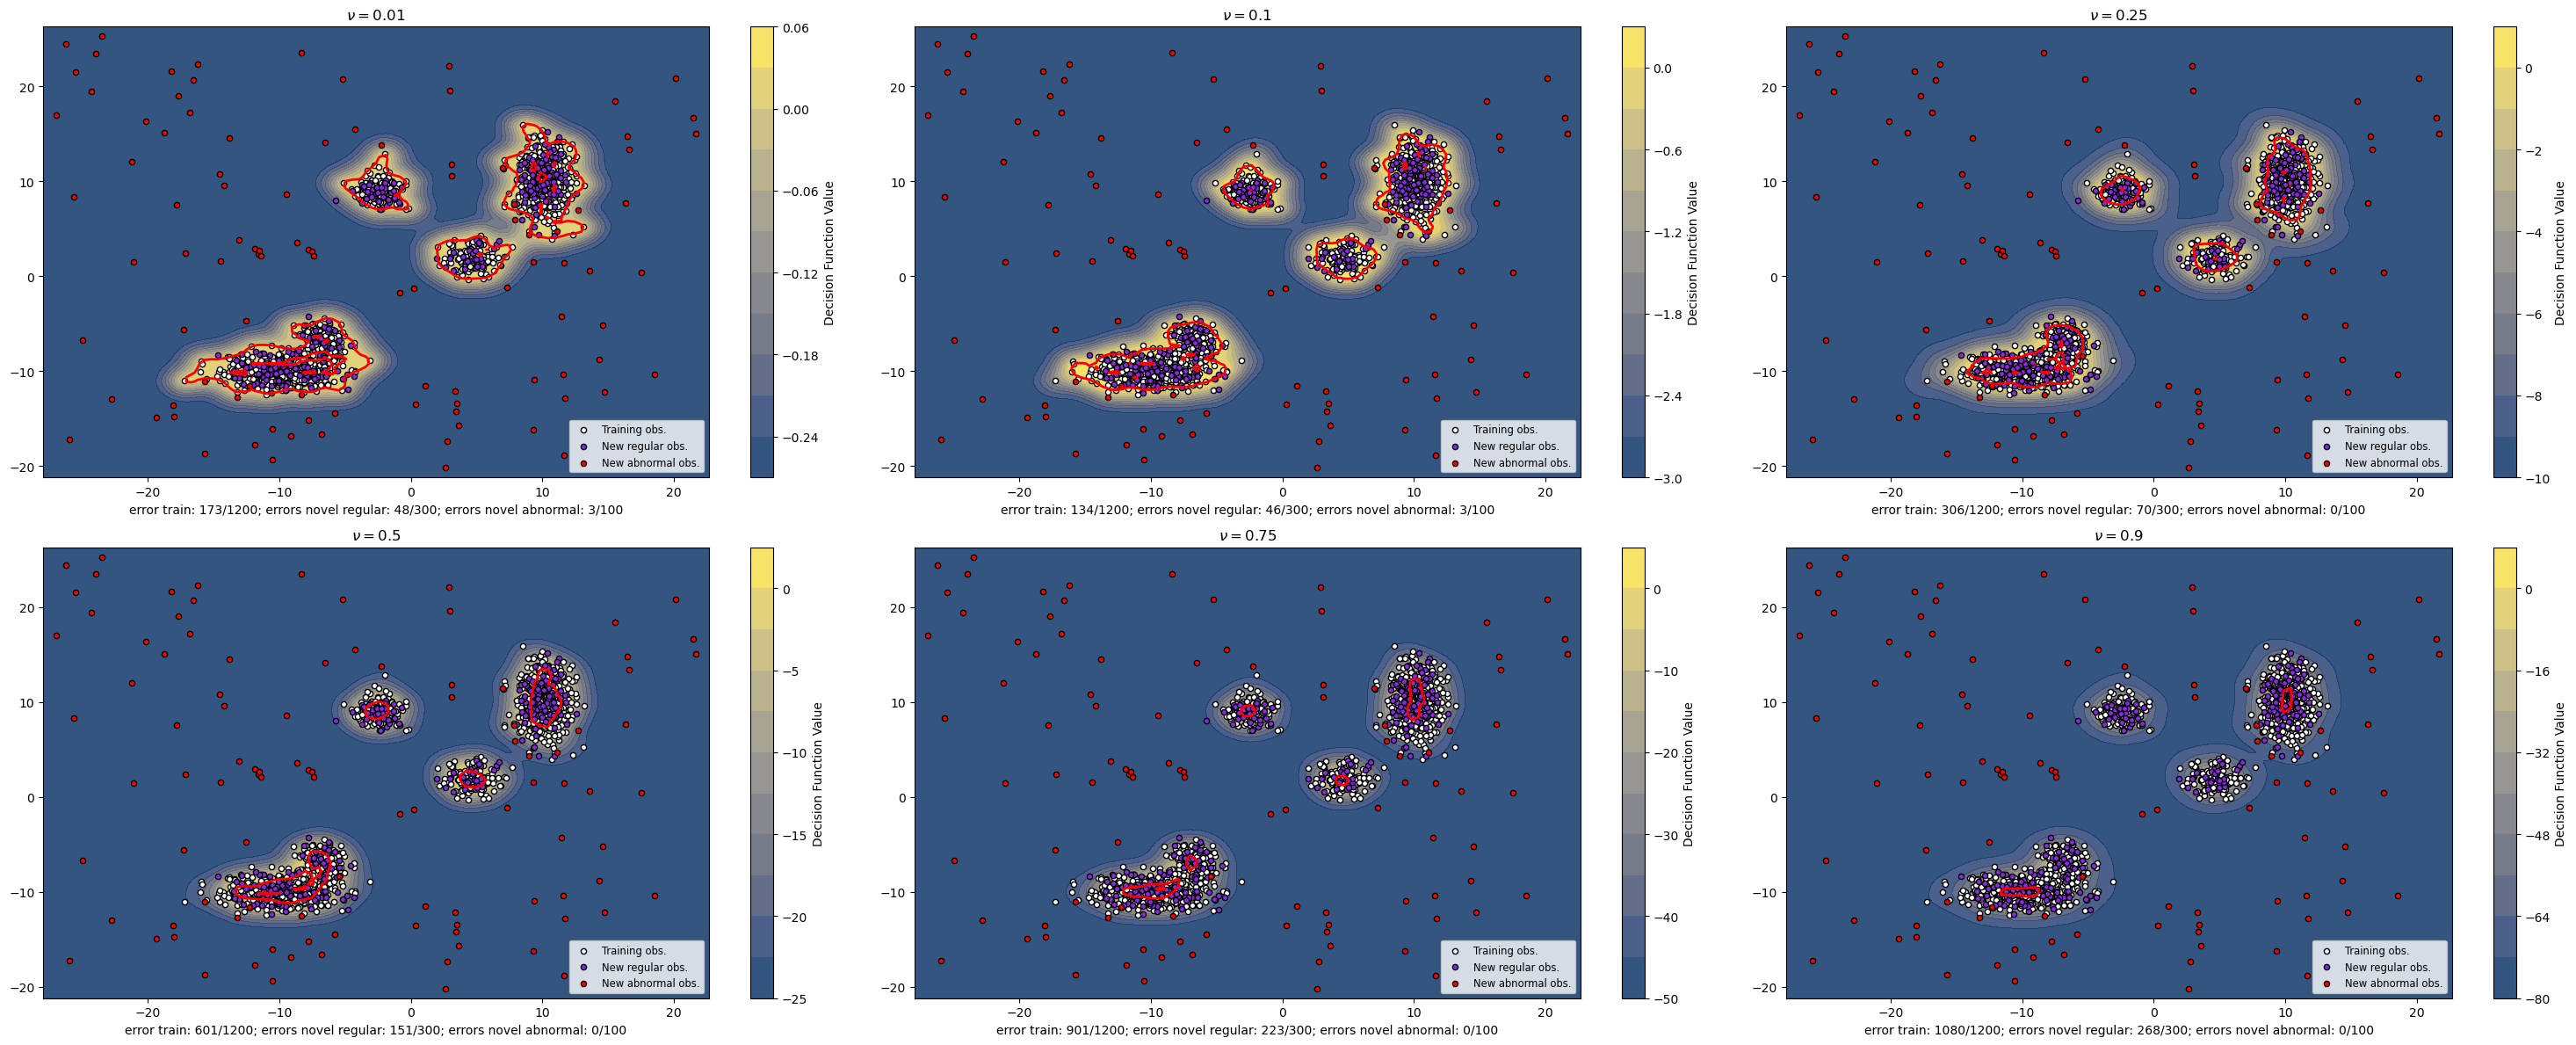

In [10]:
# Visualize decision boundaries for each model
fig, ax = plt.subplots(2, 3, figsize=(30, 12))
ax = ax.flatten()

for i, nu in enumerate([0.01, 0.1, 0.25, 0.5, 0.75, 0.9]):
    svm_clf = train_one_class_svm(X_train, nu=nu)
    plot_decision_boundary_novelty(
        svm_clf, X_train, X_test, X_outliers, ax=ax[i], title=f"$\\nu={nu}$"
    )
fig.tight_layout()

* $\gamma$ : Kernel coefficient for the Radial basis function kernel
    * if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,
    * if float, must be non-negative.
* => Un paramètre du kernel qui pondère la similarité entre les deux points
$$
    K(x, x^\prime ) = \exp (- \gamma \left\| x - x^\prime  \right\| ^2)
$$

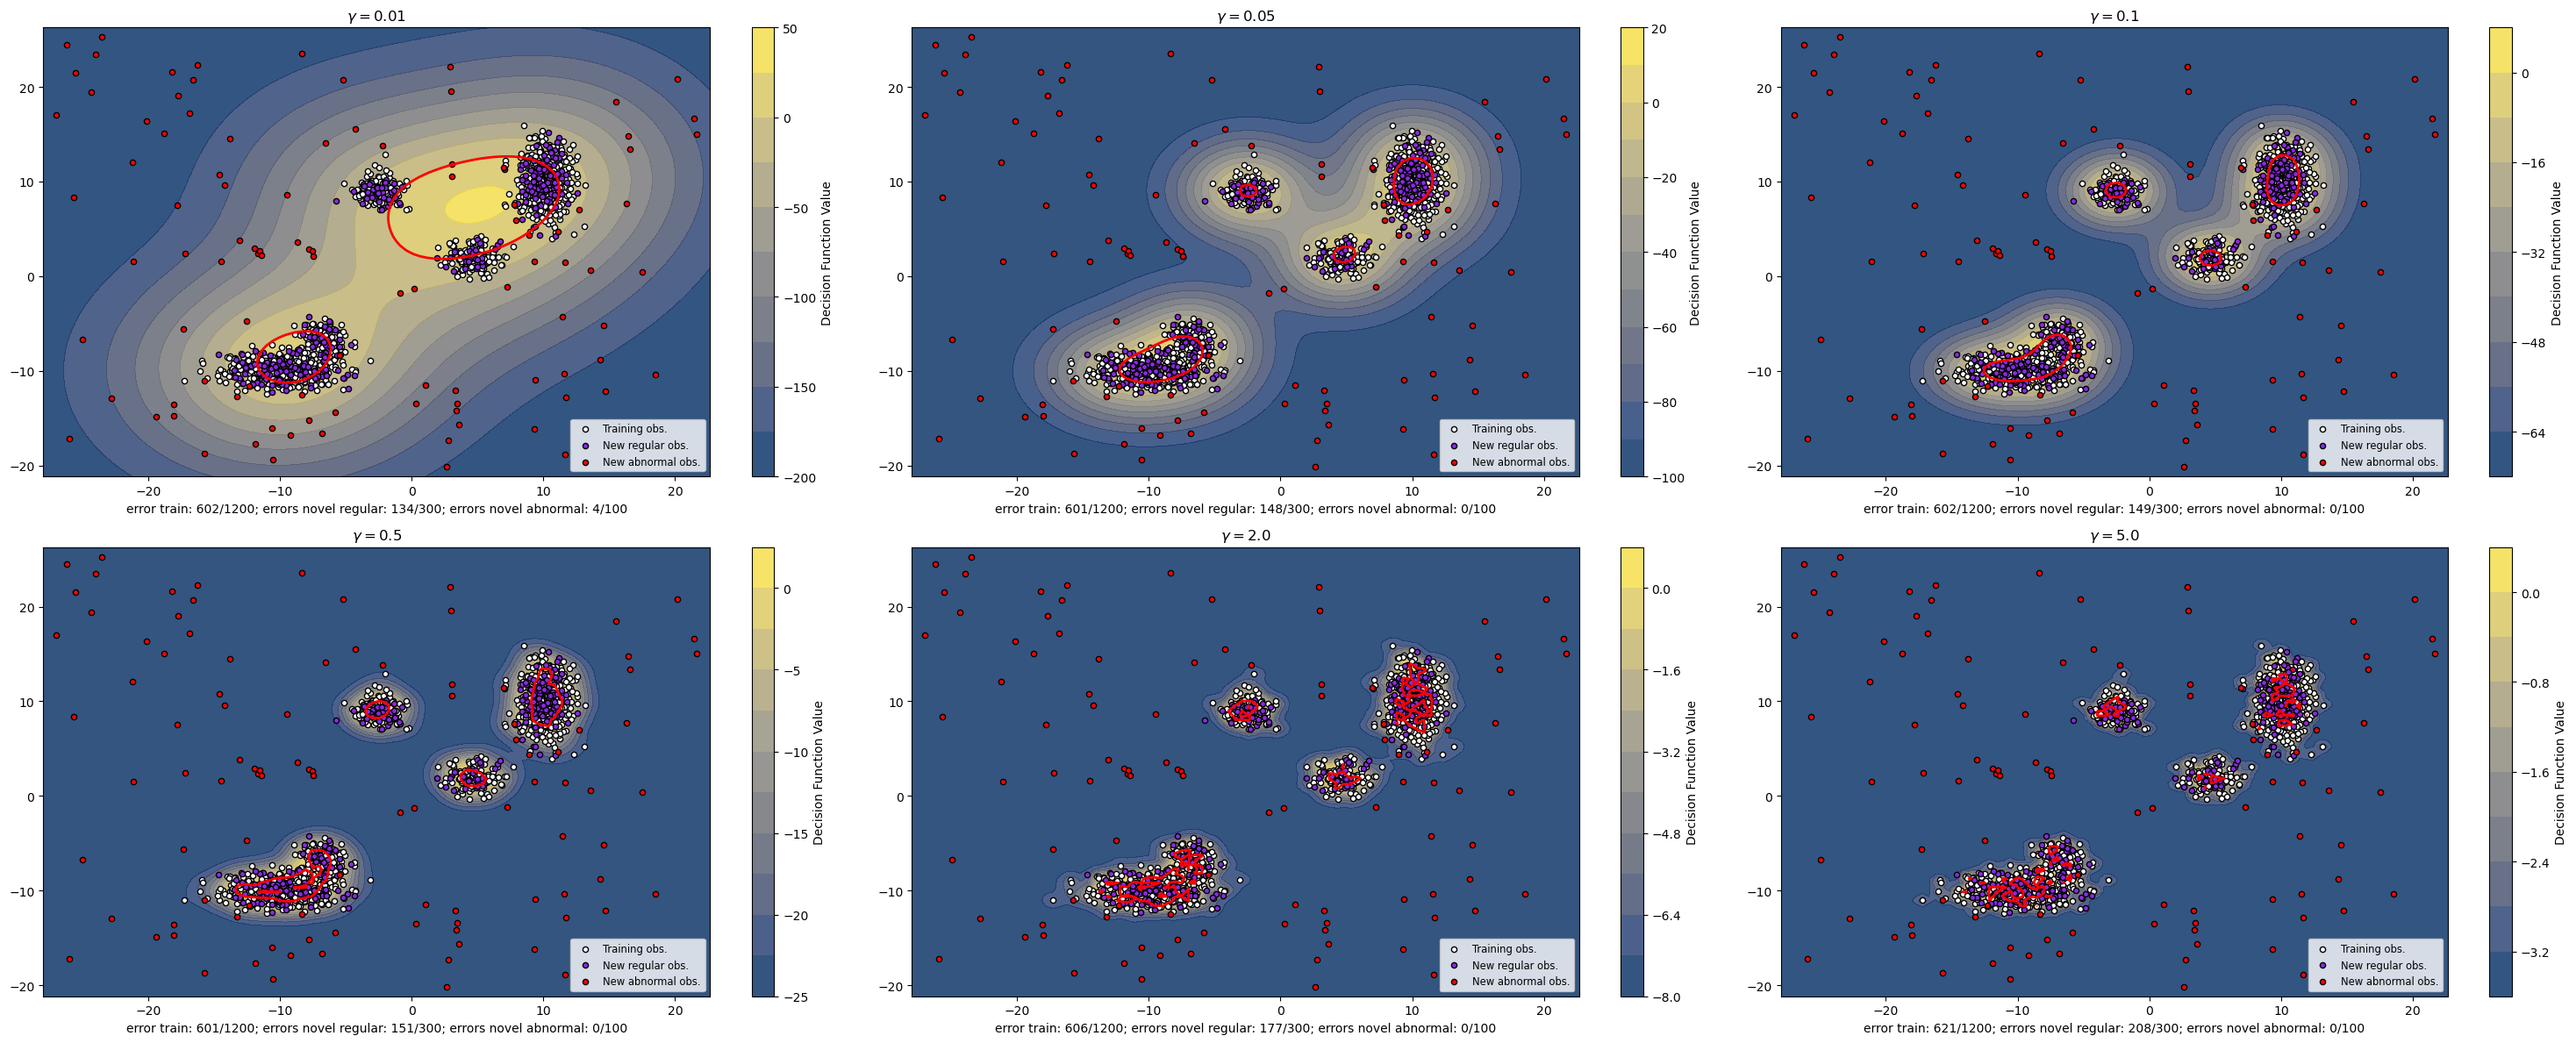

In [11]:
# Visualize decision boundaries for each model
fig, ax = plt.subplots(2, 3, figsize=(30, 12))
ax = ax.flatten()

for i, gamma in enumerate([0.01, 0.05, 0.1, 0.5, 2.0, 5.0]):
    svm_clf = train_one_class_svm(X_train, gamma=gamma)
    plot_decision_boundary_novelty(
        svm_clf, X_train, X_test, X_outliers, ax=ax[i], title=f"$\\gamma={gamma}$"
    )
fig.tight_layout()

Enfin, ce n'est pas le but de ce TME...


## <a id='toc1_3_'></a>[Explications naïves](#toc0_)


Mais pourquoi le classifieur prédit cette donnée comme exceptionnelle (ou non) ?

Pour expliquer cette prédiction, examinons d'abord les explications naïves que nous pouvons générer pour des classifieurs tels que LOF, SVM ou les arbres de décision lorsqu'ils évaluent une observation donnée, notée $x$, pour déterminer si elle est exceptionnelle ou non. L'explication mettra en évidence les modifications nécessaires pour que cette prédiction ne soit plus considérée comme une exception ou non.

Quelques pistes :

- Local Outlier Factor : Lorsque le LOF attribue une valeur très élevée à une donnée, cela signifie qu'elle est très exceptionnelle. Nous devons donc nous demander si les modifications nécessaires pour expliquer cette prédiction sont plus importantes que celles nécessaires pour un LOF moyen. Existe-t-il une corrélation entre la valeur du LOF et l'ampleur des modifications suggérées par cette explication naïve ?

- Forêt d'isolation : Contrairement au LOF, la forêt d'isolation fonctionne selon un principe différent, ce qui signifie qu'il n'y a pas nécessairement de corrélation directe avec la valeur de décision. Par conséquent, la raison sous-jacente à la prédiction d'exceptionnalité dans ce cas devrait différer de celle fournie par le LOF. Il peut être nécessaire d'utiliser des méthodes spécifiques pour les forêts, comme DIFFI.

Pour des explications plus sophistiquées, nous pouvons également considérer l'approche LIME, qui se penche sur les attributs importants dans la prise de décision du classifieur. Quels attributs sont déterminants pour que cette donnée soit considérée comme exceptionnelle par le modèle ?


### <a id='toc1_3_1_'></a>[Growing Spheres](#toc0_)

Meilleure algorithme pour produire des explications contrefactuelles dans notre situation, car on se rappelle que DiceML n'est pas adapté pour des modèles SKLearn.


In [12]:
class GrowingSpheres:
    """
    obs_to_interprete : x, une observation à interpréter
    clf : classifieur binaire
    eta : hyperparamètre
    n : nombre de points que l'on génère
    """

    def __init__(self, clf, eta, n):
        self.clf = clf
        self.eta = eta
        self.n = n

    def generate_spherical_layer(self, a0: float, a1: float) -> np.ndarray:
        """Generate a spherical layer with the specified parameters.

        :param a0: Inner radius of the spherical layer.
        :param a1: Outer radius of the spherical layer.
        :return: A numpy array representing the generated spherical layer.
        """

        def norm(v):
            return np.linalg.norm(v, ord=2, axis=1)

        z = np.random.normal(0, 1, (self.n, self.d))
        u = np.random.uniform(a0**self.d, a1**self.d, size=self.n)
        u = u ** (1 / self.d)
        z = np.array(
            [a * b / c for a, b, c in zip(z, u, norm(z))]
        )  # z = z * u / norm(z)
        return self.obs_to_interprete + z

    def find_enemy(self, spherical_layer: np.ndarray):
        """Find and update enemy information in a spherical layer.

        :param spherical_layer: A 2D numpy array representing the spherical layer data.
        :return bool: True if enemies are found in the spherical layer, False otherwise.
        """
        pred = self.clf.predict(spherical_layer)
        self.enemies = spherical_layer[pred != self.obs_predict]
        return (pred != self.obs_predict).any()

    def predict(self, obs_to_interprete):
        self.obs_to_interprete = obs_to_interprete.reshape(1, -1)
        self.obs_predict = self.clf.predict(self.obs_to_interprete)
        self.d = self.obs_to_interprete.shape[1]

        enemy = self.generation()
        return enemy, self.feature_selection(enemy)

    def generation(self):
        self.iter = 0
        spherical_layer = self.generate_spherical_layer(0, 1)
        while self.find_enemy(spherical_layer):
            self.eta /= 2
            spherical_layer = self.generate_spherical_layer(0, self.eta)
            self.iter += 1
        a0 = self.eta
        a1 = 2 * self.eta
        while not self.find_enemy(spherical_layer):
            spherical_layer = self.generate_spherical_layer(a0, a1)
            a0 = a1
            a1 = a1 + self.eta
            self.iter += 1
        return self.enemies[
            np.linalg.norm(self.enemies - self.obs_to_interprete).argmin()
        ]

    def feature_selection(self, counterfactual):
        move_sorted = sorted(
            enumerate(abs(counterfactual - self.obs_to_interprete.flatten())),
            key=lambda x: x[1],
        )
        move_sorted = [x[0] for x in move_sorted if x[1] > 0.0]
        out = counterfactual.copy()
        reduced = 0

        for k in move_sorted:
            new_enn = out.copy()
            new_enn[k] = self.obs_to_interprete.flatten()[k]
            if self.clf.predict(new_enn.reshape(1, -1)) == self.obs_predict:
                out[k] = new_enn[k]
                reduced += 1
        return out


def find_enemies(fitted_clf, obs_to_interpret, n=10, eta=2, n_gs=100):
    enemies = []
    # enemies_fs = []
    for _ in range(n):
        gs = GrowingSpheres(fitted_clf, eta, n_gs)
        enemy, _ = gs.predict(obs_to_interpret)
        enemies.append(enemy)
        # enemies_fs.append(enemy_fs)
    return np.array(enemies)  # , enemies_fs

In [61]:
import matplotlib.colors as mcolors


def visualize(
    X_train,
    X_test,
    X_outliers,
    fitted_clf,
    observations: list,
    n=10,
    eta=2,
    n_gs=100,
    ax=None,
    title=None,
    **kwds,
):
    if not ax:
        _, ax = plt.subplots()

    plot_decision_boundary_novelty(
        fitted_clf, X_train, X_test, X_outliers, ax=ax, explain=True, title=title
    )

    green_colors = {
        name: color for name, color in mcolors.CSS4_COLORS.items() if "green" in name
    }
    colors = list(green_colors.values())[: len(observations)]
    bbox_args = dict(boxstyle="round", fc="0.8")
    arrow_args = dict(arrowstyle="->")

    for obs, color in zip(observations, colors):
        enemies = find_enemies(fitted_clf, obs, n, eta, n_gs, **kwds)
        avg_enemy = enemies.mean(0)
        distance_2D = avg_enemy - obs
        distance_eucl = np.linalg.norm(distance_2D)

        obs_moved = (obs[0] + distance_2D[0], obs[1] + distance_2D[1])

        # Plot l'observation à interpréter
        ax.scatter(*obs, c="red", edgecolor="k", marker="o", label="Obs.", s=100)

        # Plot les exemples contrefactuels de l'observation à interpréter
        ax.scatter(
            enemies[:, 0],
            enemies[:, 1],
            c=color,
            edgecolor="k",
            marker="*",
            label="Enemies",
            s=200,
        )

        # Plot l'outlier déplacé
        ax.scatter(
            obs_moved[0],
            obs_moved[1],
            c="blueviolet",
            edgecolor="k",
            marker="o",
            s=100,
            label="Obs. déplacée",
        )

        # Explique les observations
        xy = (obs[0], obs[1])
        text_shift = -25.0 if obs[0] >= 5 else 5.0
        xytext = (obs[0] + text_shift, obs[1] - 5.0)

        decision_value = fitted_clf.decision_function(obs.reshape(1, -1))
        predicted_value = fitted_clf.predict(obs.reshape(1, -1))
        description = f"""Décision : {decision_value[0]:.2f}
            Prédiction : {predicted_value[0]}
            Distance $(x, y)$ : {distance_2D[0]:.1f}, {distance_2D[1]:.1f}
            Distance euclidienne : {distance_eucl:.1f}"""
        description = "\n".join(line.lstrip() for line in description.split("\n"))

        ax.annotate(
            description,
            xy=xy,
            xytext=xytext,
            xycoords="data",
            textcoords="data",
            bbox=bbox_args,
            arrowprops=arrow_args,
        )

    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.07), ncol=5)
    return ax

#### <a id='toc1_3_1_1_'></a>[LOF - Explications contrefactuelles](#toc0_)


##### <a id='toc1_3_1_1_1_'></a>[3 clusters (distributions normales multidimensionnelles)](#toc0_)


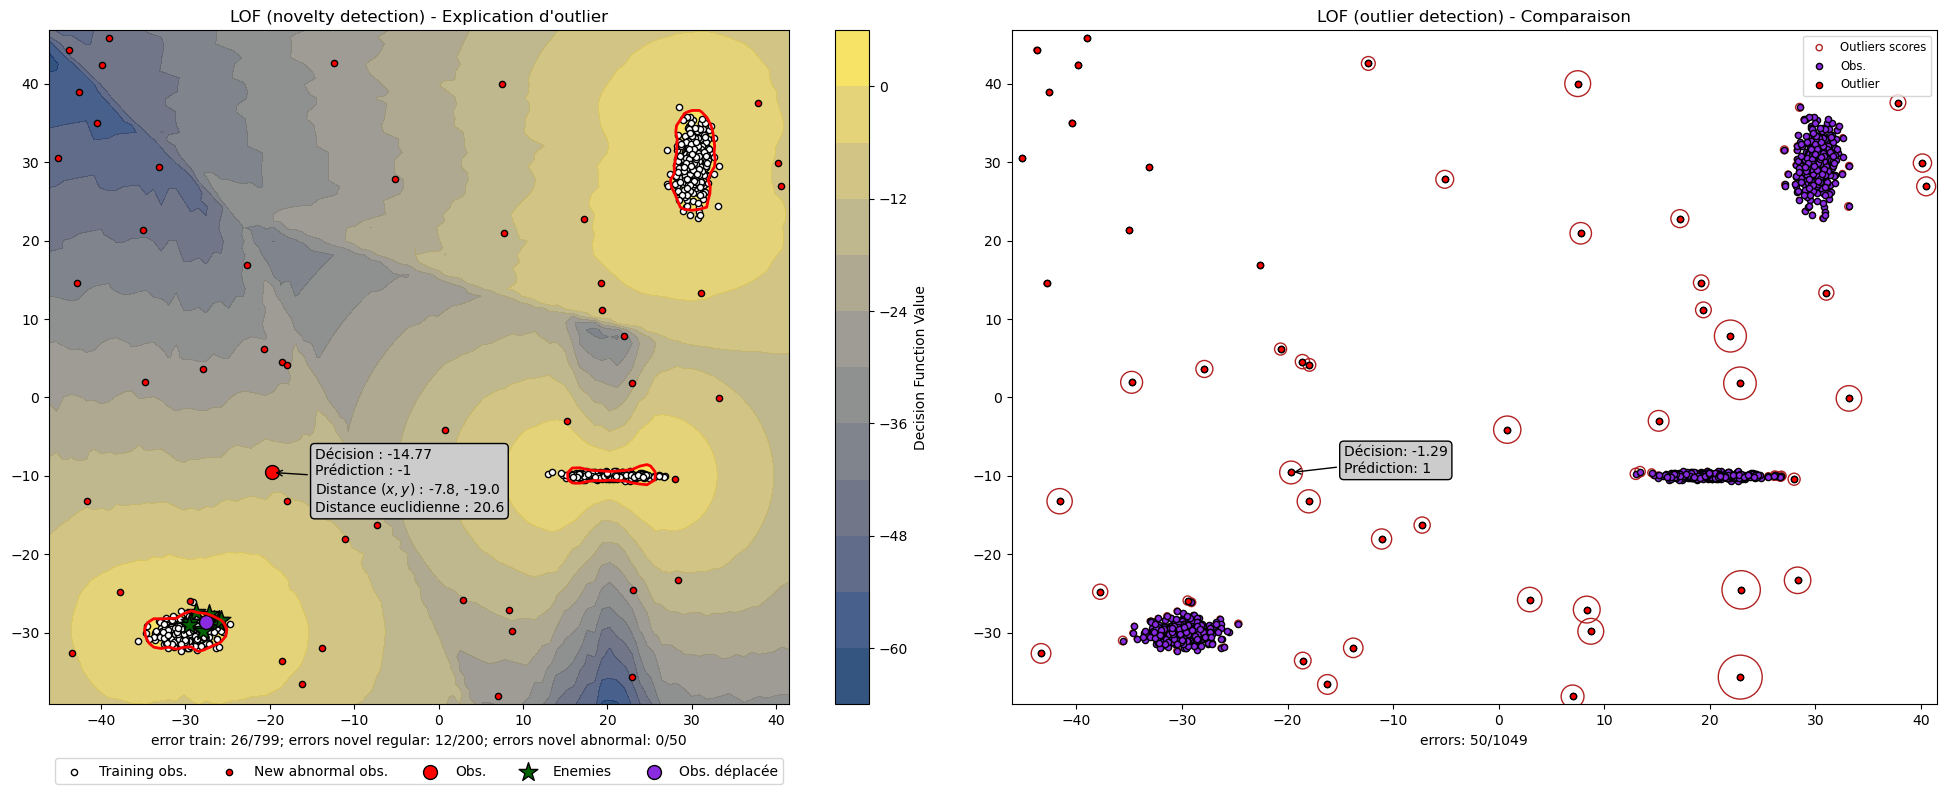

In [56]:
centers = [(-30, -30), (20, -10), (30, 30)]
cov = [
    np.array([[3, 0], [0, 1]]),
    np.array([[7, 0], [0, 0.05]]),
    np.array([[1, 0], [0, 7]]),
]
X_train, X_test, X_outliers = generate_elongated(n_clusters=3, centers=centers, cov=cov)
X = np.vstack((X_train, X_test, X_outliers))
lof_clf_outlier = train_lof(X, mode=False)
lof_clf_novelty = train_lof(X_train, mode=True)
y_pred = lof_clf_outlier.fit_predict(X)

idx = 10  # np.random.randint(X_outliers.shape[0])
obs = X_outliers[idx]

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
title = "LOF (novelty detection) - Explication d'outlier"
visualize(X_train, X_test, X_outliers, lof_clf_novelty, [obs], ax=ax[0], title=title)

## Outlier detection
title = "LOF (outlier detection) - Comparaison"
plot_decision_boundary_outlier(lof_clf_outlier, X, X_outliers, ax=ax[1], title=title)
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")
xy = (obs[0], obs[1])
xytext = (obs[0] + 5.0, obs[1])
ax[1].annotate(
    f"Décision: {lof_clf_outlier.negative_outlier_factor_[idx]:.2f}\nPrédiction: {y_pred[idx]}",
    xy=xy,
    xytext=xytext,
    xycoords="data",
    textcoords="data",
    bbox=bbox_args,
    arrowprops=arrow_args,
)

fig.tight_layout()

La distance $(x, y)$ correspond aux valeurs pour laquelles notre observation doit se déplacer sur l'axe (horizontal, vertical) pour appartenir à l'autre classe. Ici, étant donné qu'on étudie les exceptions (outliers), on regarde de **combien l'outlier devrait se déplacer sur la grille pour faire partie d'un cluster**. Par exemple, ici, l'outlier devrait se déplacer de 7 vers la gauche et de 19 vers le bas pour ne pas être une exception.


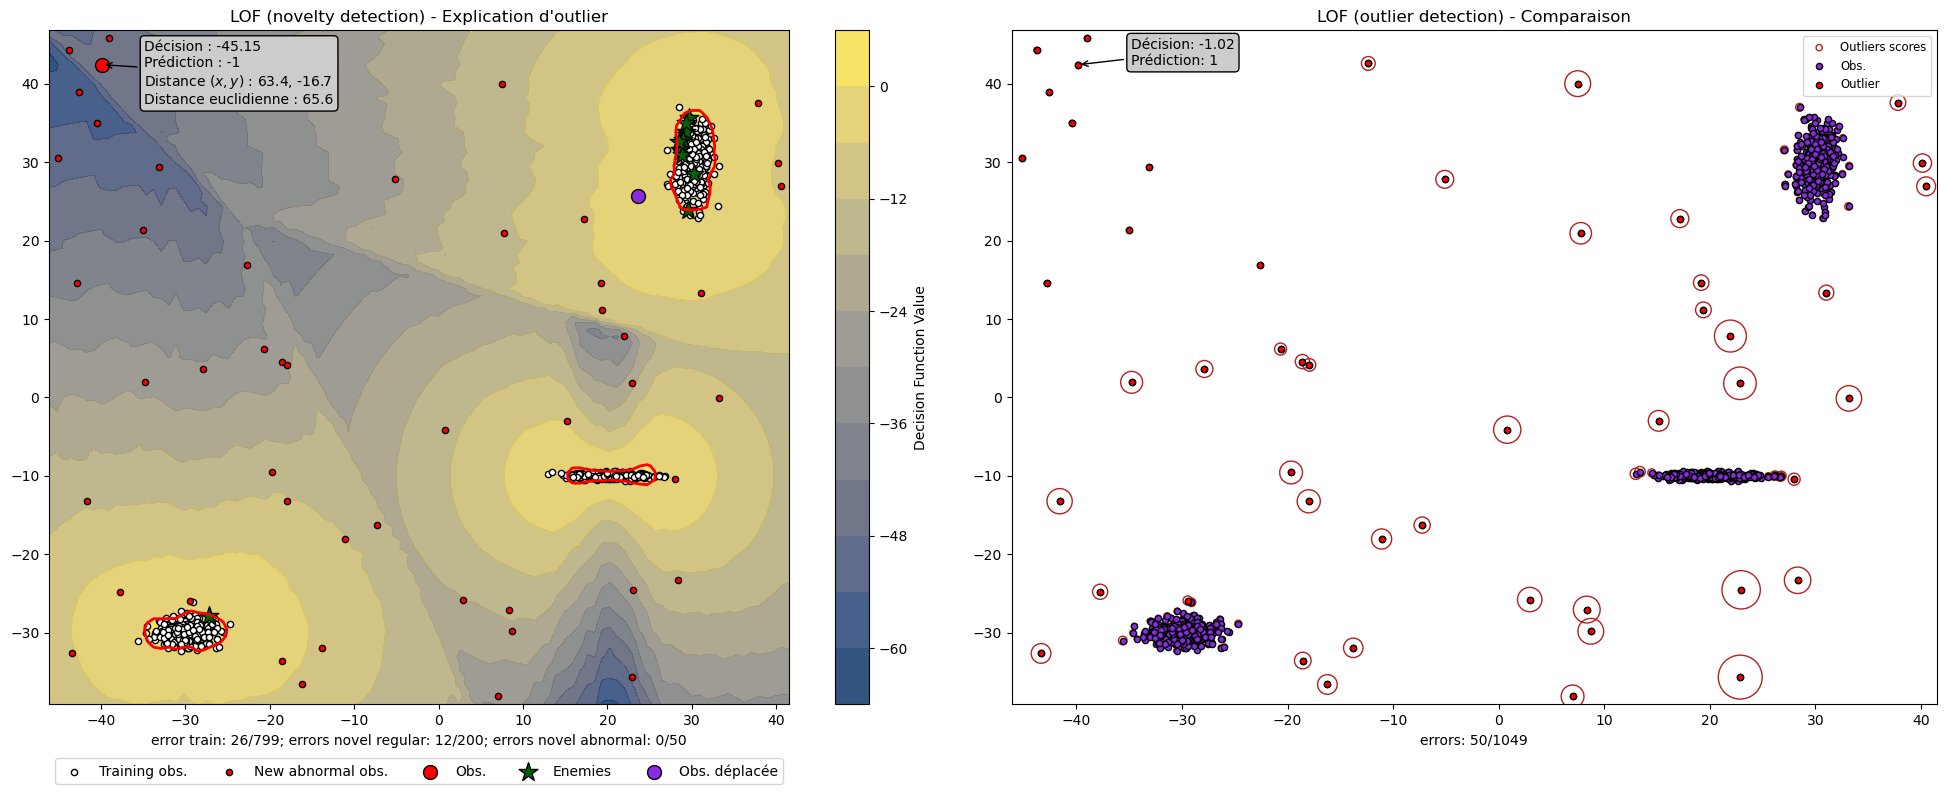

In [57]:
centers = [(-30, -30), (20, -10), (30, 30)]
cov = [
    np.array([[3, 0], [0, 1]]),
    np.array([[7, 0], [0, 0.05]]),
    np.array([[1, 0], [0, 7]]),
]
X_train, X_test, X_outliers = generate_elongated(n_clusters=3, centers=centers, cov=cov)
X = np.vstack((X_train, X_test, X_outliers))
lof_clf_outlier = train_lof(X, mode=False)
lof_clf_novelty = train_lof(X_train, mode=True)
y_pred = lof_clf_outlier.fit_predict(X)

idx = 15
obs = X_outliers[idx]

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
title = "LOF (novelty detection) - Explication d'outlier"
visualize(X_train, X_test, X_outliers, lof_clf_novelty, [obs], ax=ax[0], title=title)

## Outlier detection
title = "LOF (outlier detection) - Comparaison"
plot_decision_boundary_outlier(lof_clf_outlier, X, X_outliers, ax=ax[1], title=title)

bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")
xy = (obs[0], obs[1])
xytext = (obs[0] + 5.0, obs[1])
ax[1].annotate(
    f"Décision: {lof_clf_outlier.negative_outlier_factor_[idx]:.2f}\nPrédiction: {y_pred[idx]}",
    xy=xy,
    xytext=xytext,
    xycoords="data",
    textcoords="data",
    bbox=bbox_args,
    arrowprops=arrow_args,
)

fig.tight_layout()

> Pourquoi, en mode "outlier" (et pas en mode "novelty"), LOF prédit une bonne partie des outliers de la partie gauche comme un grand cluster ?

C'est une sensibilité aux hyper-paramètres, ici le nombre de voisins (`n_neighbors`), prendre un nombre plus élevé _devrait_ résoudre notre problème.


Une autre observation intéressante : que se passe-t-il quand une exception est au milieu de plusieurs clusters ? <br/> Sans surprise, l'algorithme d'explication propose des contrefactuels dans deux clusters différents, à équi-distance. Mais, en réalité, si ces clusters étaient tous les trois d'origines différentes, comme faire la différence ? Ce n'est pas possible de faire cette distinction avec notre méthode. C'est une limite de Growing Spheres, car ici, vu qu'on explique avec le contrefactuel **moyen**, l'outlier peut potentiellement rester un outlier... De par le côté aléatoire de Growing Spheres, on peut aisément penser que ça arriverait dans 50 % des cas.


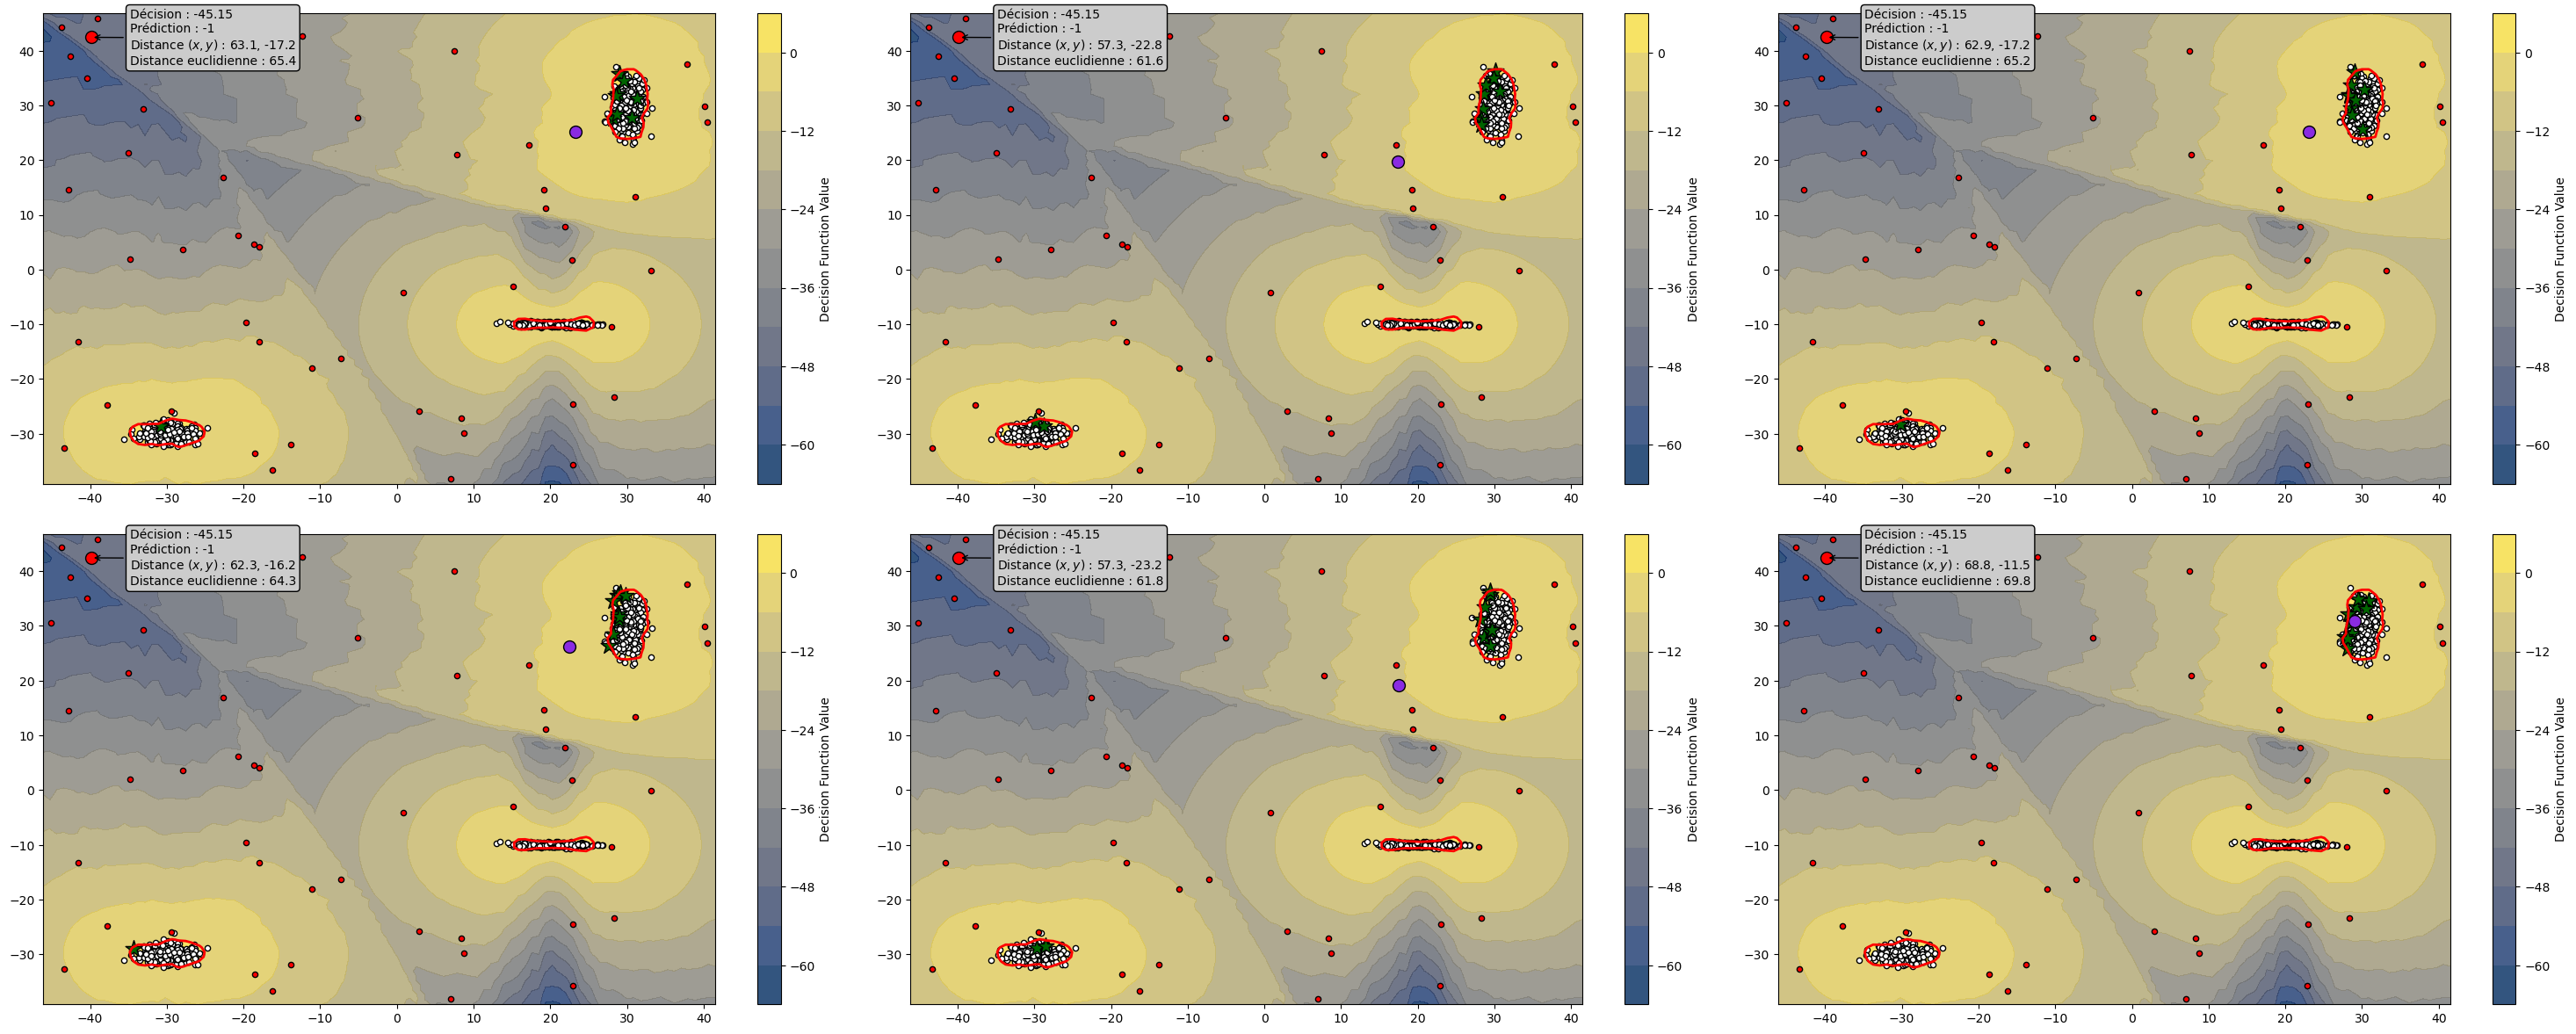

In [29]:
fig, ax = plt.subplots(2, 3, figsize=(30, 12))
ax = ax.flatten()

for i, _ in enumerate(ax):
    visualize(X_train, X_test, X_outliers, lof_clf_novelty, [obs], ax=ax[i])
    ax[i].set_xlabel(None)
    ax[i].get_legend().remove()

fig.tight_layout()

Dans la figure suivante, nous avons tenté de montrer une corrélation entre la valeur de la fonction de décision ou du score LOF (en fonction du mode d'apprentissage : outiler ou novelty) et la distance entre un outlier et un exemple contrefactuel moyen.

> **Note :** En avançant dans le TME, en améliorant le code et les sorties, on parvient finalement à avoir un bon graphique, ce qui n'était pas le cas avant. Il y avait une sorte de croix qui se dessinait, faisant écho à la phrase suivante initialement écrite pour les deux graphiques (gauche et droite). Cette interprétation peut rester valable dans le cas de LOF en mode supervisé (graphique de droite).

Dans le contexte de clusters multiples, montrer une corrélation n'est pas simple car la valeur de la fonction de décision pour un point peut être affectée par le cluster auquel il est comparé, voire par la densité et la forme des clusters eux-mêmes. Par conséquent, la corrélation ne reflète pas simplement la distance par rapport au cluster le plus proche, mais elle est influencée par la position relative d'un point par rapport à toutes les grappes (cluster). On _devine_ cependant une corrélation.

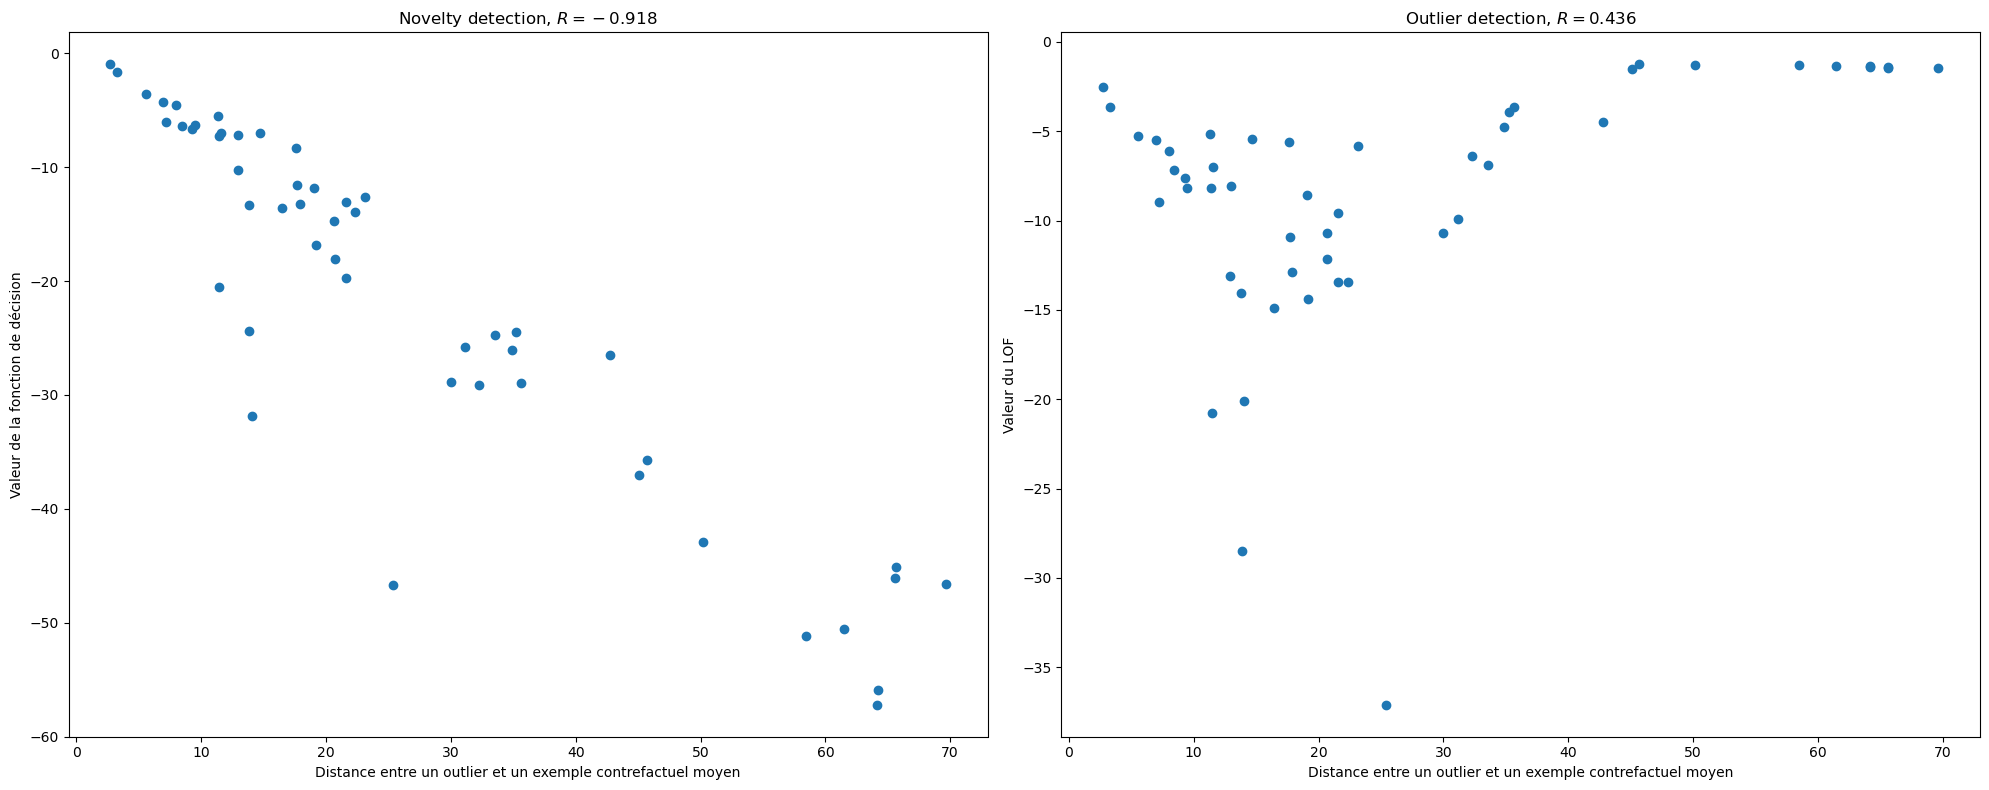

In [30]:
expl_outliers = []
for outlier in X_outliers:
    enemies = find_enemies(lof_clf_novelty, outlier)
    avg_enemy = enemies.mean(0)
    expl_outliers.append(np.linalg.norm(outlier - avg_enemy))

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
decision_outliers = lof_clf_novelty.decision_function(X_outliers)
corr = np.corrcoef(expl_outliers, decision_outliers)[0, 1]
ax[0].scatter(expl_outliers, decision_outliers)
ax[0].set_xlabel("Distance entre un outlier et un exemple contrefactuel moyen")
ax[0].set_ylabel("Valeur de la fonction de décision")
ax[0].set_title(f"Novelty detection, $R = {corr:.3f}$")

lof_value = lof_clf_outlier.negative_outlier_factor_[-len(X_outliers) :]
corr = np.corrcoef(expl_outliers, lof_value)[0, 1]
ax[1].scatter(expl_outliers, lof_value)
ax[1].set_xlabel("Distance entre un outlier et un exemple contrefactuel moyen")
ax[1].set_ylabel("Valeur du LOF")
ax[1].set_title(f"Outlier detection, $R = {corr:.3f}$")

fig.tight_layout()

##### <a id='toc1_3_1_1_2_'></a>[2 clusters (distributions normales multidimensionnelles)](#toc0_)


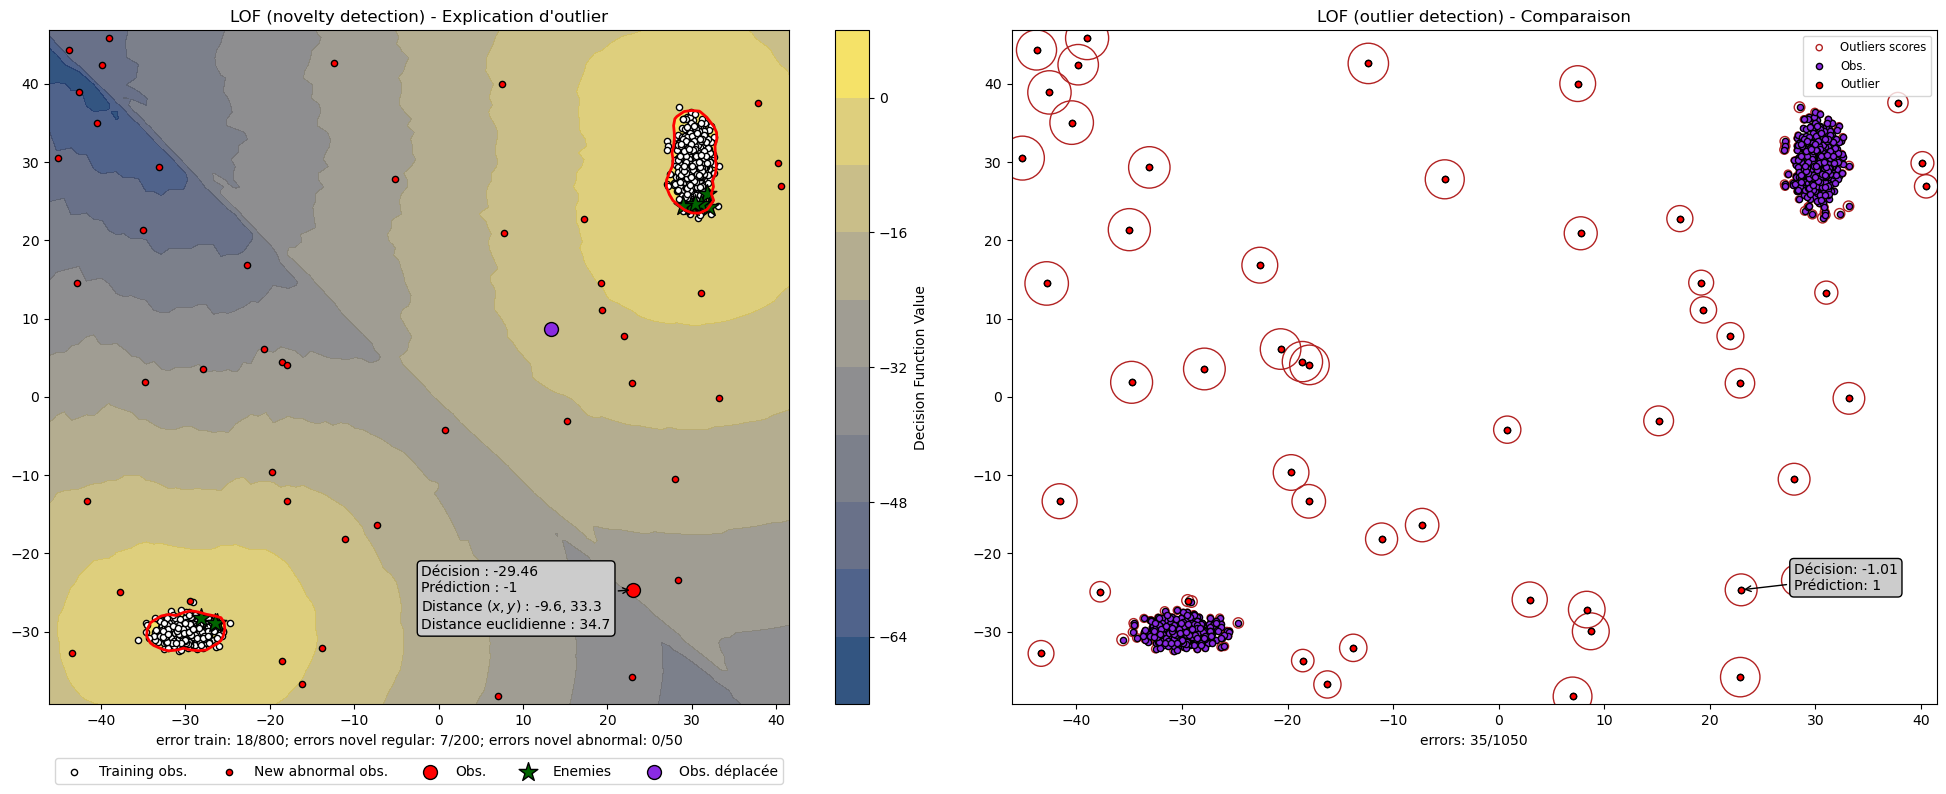

In [62]:
centers = [(-30, -30), (30, 30)]
cov = [np.array([[3, 0], [0, 1]]), np.array([[1, 0], [0, 7]])]
X_train, X_test, X_outliers = generate_elongated(n_clusters=2, centers=centers, cov=cov)
X = np.vstack((X_train, X_test, X_outliers))
lof_clf_outlier = train_lof(X, n_neighbors=50, mode=False)
lof_clf_novelty = train_lof(X_train, mode=True)
y_pred = lof_clf_outlier.fit_predict(X)

idx = 34  # np.random.randint(X_outliers.shape[0])
obs = X_outliers[idx]

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
title = "LOF (novelty detection) - Explication d'outlier"
visualize(X_train, X_test, X_outliers, lof_clf_novelty, [obs], ax=ax[0], title=title)

## Outlier detection
title = "LOF (outlier detection) - Comparaison"
plot_decision_boundary_outlier(lof_clf_outlier, X, X_outliers, ax=ax[1], title=title)
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")
xy = (obs[0], obs[1])
xytext = (obs[0] + 5.0, obs[1])
ax[1].annotate(
    f"Décision: {lof_clf_outlier.negative_outlier_factor_[idx]:.2f}\nPrédiction: {y_pred[idx]}",
    xy=xy,
    xytext=xytext,
    xycoords="data",
    textcoords="data",
    bbox=bbox_args,
    arrowprops=arrow_args,
)
fig.tight_layout()

Une fois de plus, prendre une exception entre deux clusters est une limitation (si on se base sur un contrefactuel moyen) : une solution serait de tirer un seul ennemi aléatoirement pour calculer la distance.

Prendre un nombre de voisins plus élevés (50 contre 20 précedémment) améliore nettement la détection des outliers (graphe de droite). $\rightarrow$ LOF est sensible aux choix des hyper-paramètres.


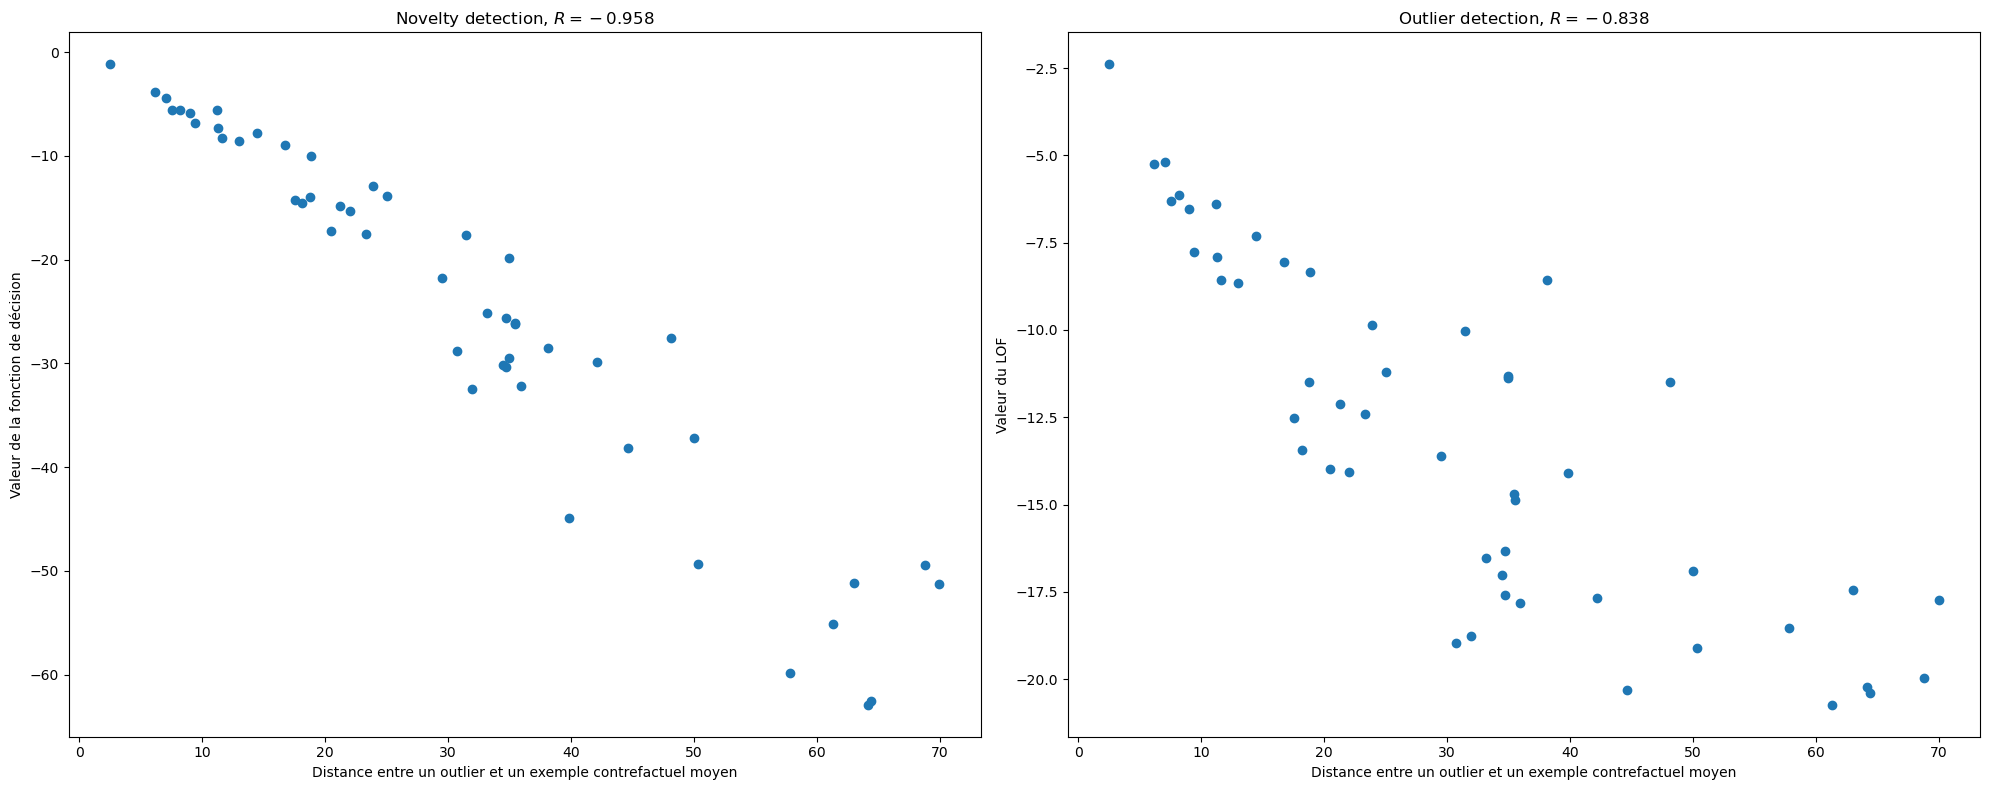

In [32]:
expl_outliers = []
for outlier in X_outliers:
    enemies = find_enemies(lof_clf_novelty, outlier)
    avg_enemy = enemies.mean(0)
    expl_outliers.append(np.linalg.norm(outlier - avg_enemy))

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
decision_outliers = lof_clf_novelty.decision_function(X_outliers)
corr = np.corrcoef(expl_outliers, decision_outliers)[0, 1]
ax[0].scatter(expl_outliers, decision_outliers)
ax[0].set_xlabel("Distance entre un outlier et un exemple contrefactuel moyen")
ax[0].set_ylabel("Valeur de la fonction de décision")
ax[0].set_title(f"Novelty detection, $R = {corr:.3f}$")

lof_value = lof_clf_outlier.negative_outlier_factor_[-len(X_outliers) :]
corr = np.corrcoef(expl_outliers, lof_value)[0, 1]
ax[1].scatter(expl_outliers, lof_value)
ax[1].set_xlabel("Distance entre un outlier et un exemple contrefactuel moyen")
ax[1].set_ylabel("Valeur du LOF")
ax[1].set_title(f"Outlier detection, $R = {corr:.3f}$")

fig.tight_layout()

Ici, une corrélation se dessine dans les 2 cas, affirmant notre intuition !


#### <a id='toc1_3_1_2_'></a>[1 cluster (blob)](#toc0_)


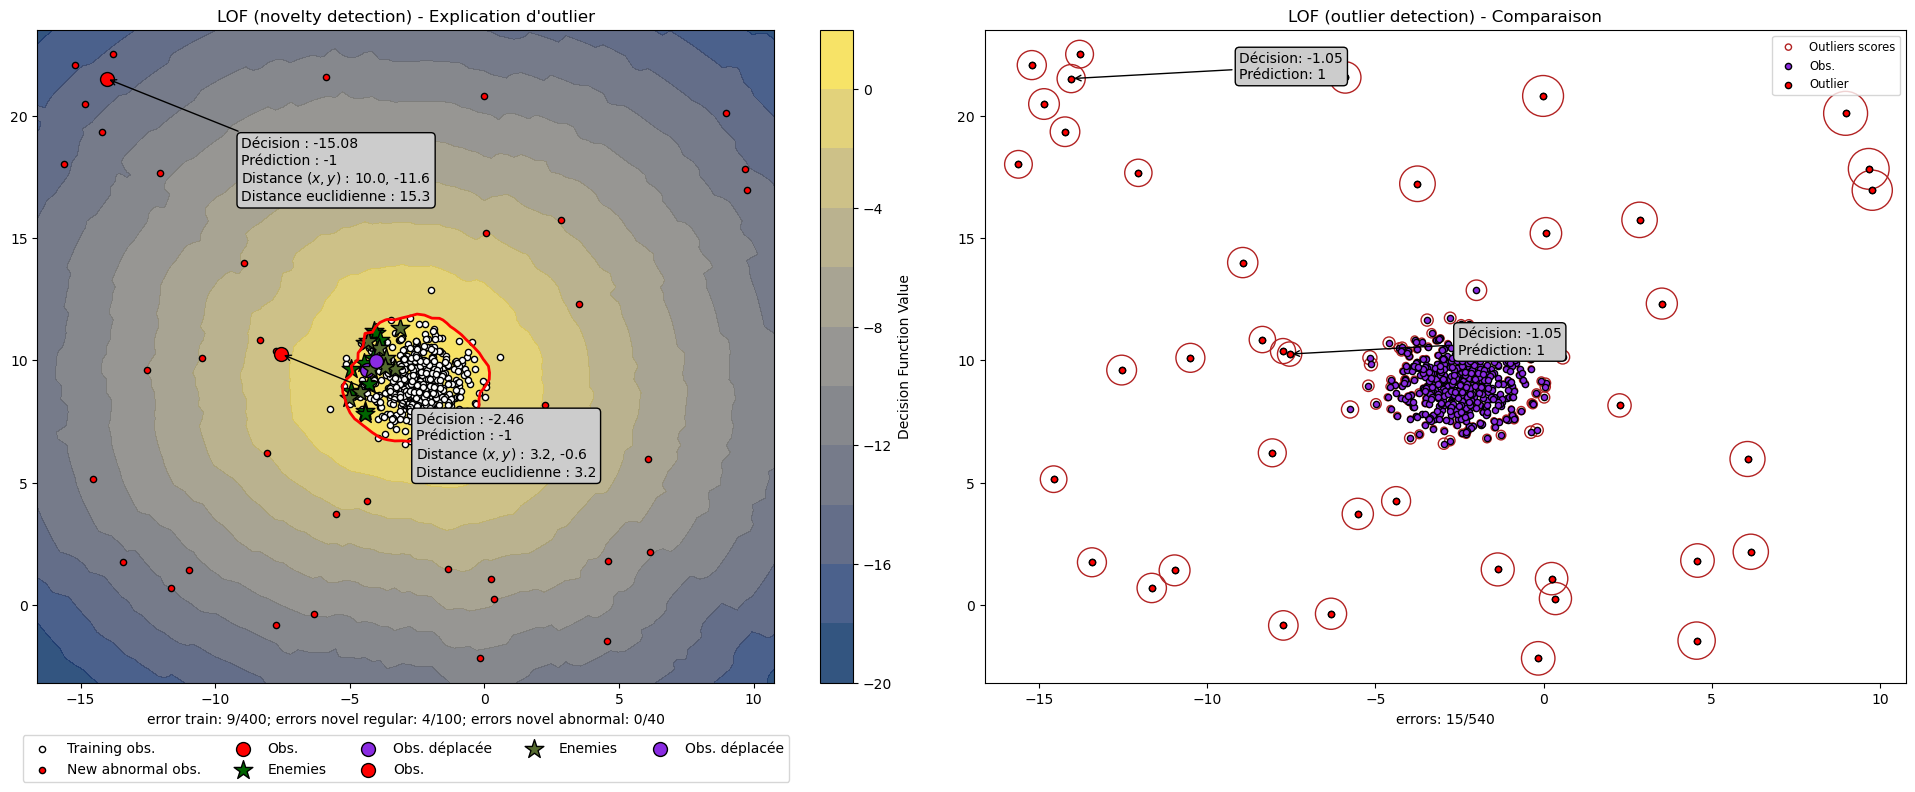

In [63]:
X_train, X_test, X_outliers = generate_blobs(n_samples=500, n_clusters=1, n_outliers=40)
X = np.vstack((X_train, X_test, X_outliers))
lof_clf_outlier = train_lof(X, mode=False)
lof_clf_novelty = train_lof(X_train, mode=True)
y_pred = lof_clf_outlier.fit_predict(X)

close_obs = X_outliers[23]
far_obs = X_outliers[16]

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
title = "LOF (novelty detection) - Explication d'outlier"
visualize(
    X_train,
    X_test,
    X_outliers,
    lof_clf_novelty,
    [close_obs, far_obs],
    ax=ax[0],
    title=title,
)

## Outlier detection
title = "LOF (outlier detection) - Comparaison"
plot_decision_boundary_outlier(lof_clf_outlier, X, X_outliers, ax=ax[1], title=title)
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")

xy = (close_obs[0], close_obs[1])
xytext = (close_obs[0] + 5.0, close_obs[1])
ax[1].annotate(
    f"Décision: {lof_clf_outlier.negative_outlier_factor_[idx]:.2f}\nPrédiction: {y_pred[idx]}",
    xy=xy,
    xytext=xytext,
    xycoords="data",
    textcoords="data",
    bbox=bbox_args,
    arrowprops=arrow_args,
)

xy = (far_obs[0], far_obs[1])
xytext = (far_obs[0] + 5.0, far_obs[1])
ax[1].annotate(
    f"Décision: {lof_clf_outlier.negative_outlier_factor_[idx]:.2f}\nPrédiction: {y_pred[idx]}",
    xy=xy,
    xytext=xytext,
    xycoords="data",
    textcoords="data",
    bbox=bbox_args,
    arrowprops=arrow_args,
)


fig.tight_layout()

Un autre point important à souligner : LOF en mode supervisé donne un score borné, là où en mode non supervisé la fonction de décision est beaucoup plus libre, nous permettant beaucoup plus aisément de démontrer une corrélation, comme le montre les graphiques ci-dessus.

Sur le graphique de droite, nos deux outliers ont la même valeur de décision (-1.82) alors qu'ils ne sont pas à la même distance, là où sur le graphique de gauche, ce n'est pas le cas.


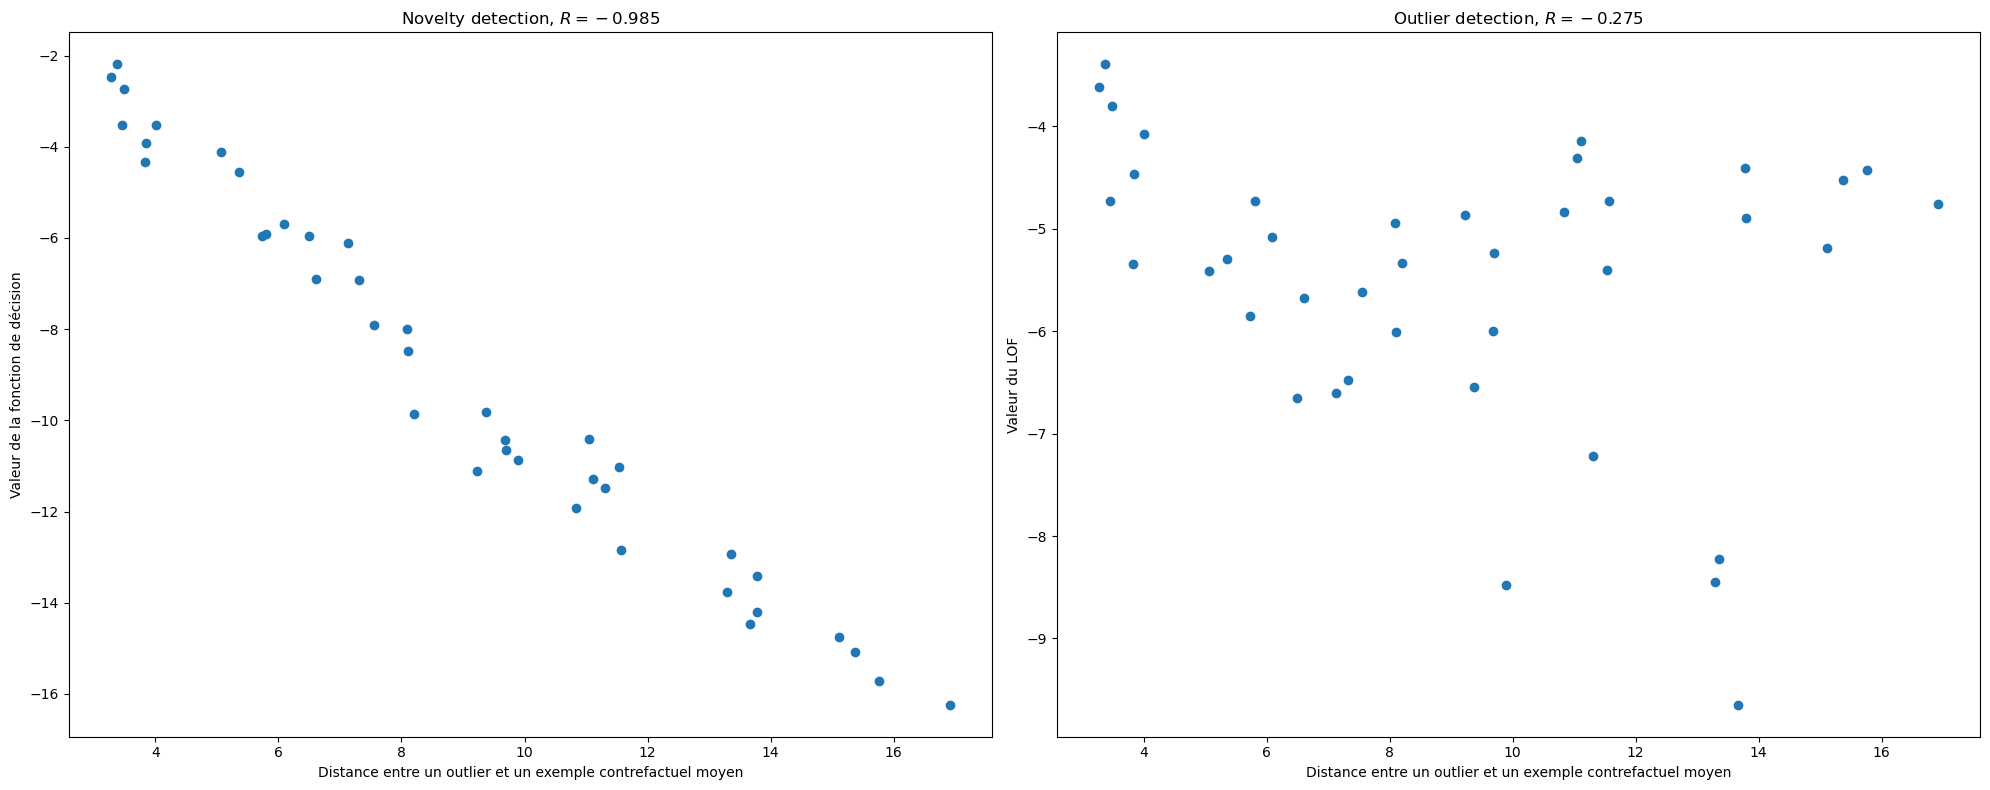

In [34]:
expl_outliers = []
for outlier in X_outliers:
    enemies = find_enemies(lof_clf_novelty, outlier)
    avg_enemy = enemies.mean(0)
    expl_outliers.append(np.linalg.norm(outlier - avg_enemy))

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
decision_outliers = lof_clf_novelty.decision_function(X_outliers)
corr = np.corrcoef(expl_outliers, decision_outliers)[0, 1]
ax[0].scatter(expl_outliers, decision_outliers)
ax[0].set_xlabel("Distance entre un outlier et un exemple contrefactuel moyen")
ax[0].set_ylabel("Valeur de la fonction de décision")
ax[0].set_title(f"Novelty detection, $R = {corr:.3f}$")

lof_value = lof_clf_outlier.negative_outlier_factor_[-len(X_outliers) :]
corr = np.corrcoef(expl_outliers, lof_value)[0, 1]
ax[1].scatter(expl_outliers, lof_value)
ax[1].set_xlabel("Distance entre un outlier et un exemple contrefactuel moyen")
ax[1].set_ylabel("Valeur du LOF")
ax[1].set_title(f"Outlier detection, $R = {corr:.3f}$")

fig.tight_layout()

**CCL**: Ainsi, comme anticipé par l'intuitition, il existe bien une corrélation ($R$ très élevé !!) entre la distance entre l'outlier et la valeur de décision du classifieur, mais, seulement lorsque l'on fait de la classification d'outlier non-supervisé (novelty).


#### <a id='toc1_3_1_3_'></a>[One-Class SVM - Explications contrefactuelles](#toc0_)


predictions : -1 -1 -1


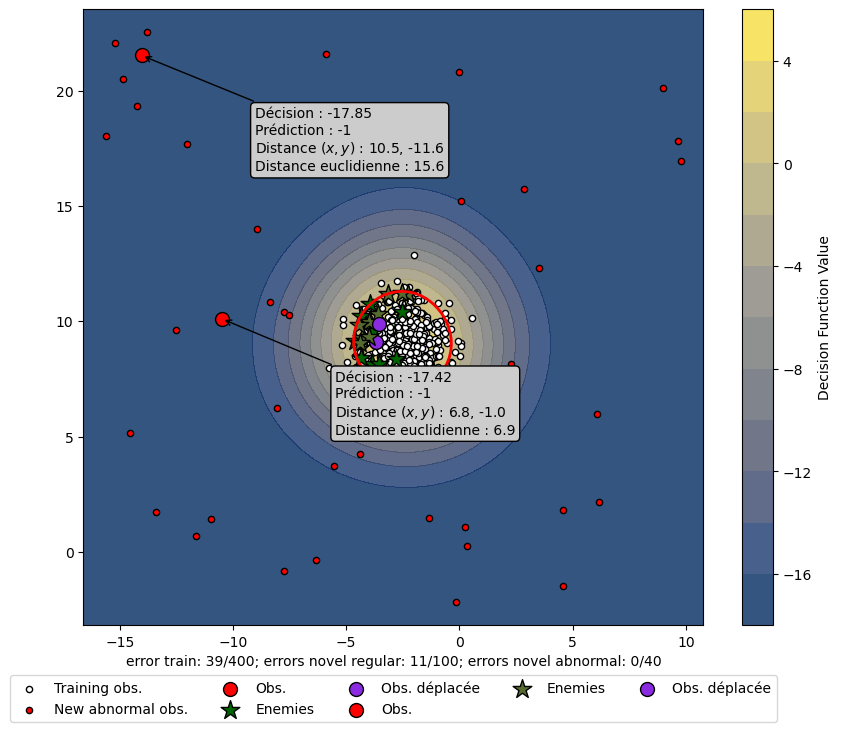

In [84]:
svm_clf = train_one_class_svm(X_train, nu=0.1, gamma=0.1)
y_pred = svm_clf.predict(X_test)
y_pred_outliers = iso_forest_clf.predict(X_outliers)

obs = X_outliers[13]

fig, ax = plt.subplots(figsize=(10, 8))
visualize(X_train, X_test, X_outliers, svm_clf, [obs, far_obs], ax=ax)
print("predictions :", y_pred_outliers[7], y_pred_outliers[20], y_pred_outliers[16])

Pour le SVM, les frontières étant beaucoup plus marquées, il n'y aura pas de corrélation entre distance et valeur de la fonction de décision. Il est très visible que passé une certaine distance, les outliers auront une valeur assignée autour de -16, quelque soit la distance.

Nous examinons deux outliers à la frontière de classification du One-Class SVM. Le premier, bien que proche avec une distance de 7, reçoit une valeur de décision de -17.42, le classant comme une exception. Le second, bien plus éloigné, est aussi classé comme une exception avec une valeur de décision de -17.85, suggérant que la valeur de décision ne double pas même si la distance le fait. Les prédictions restent correctes.

#### <a id='toc1_3_1_4_'></a>[Isolation Forest - Explications contrefactuelles](#toc0_)


preds : -1 -1 -1


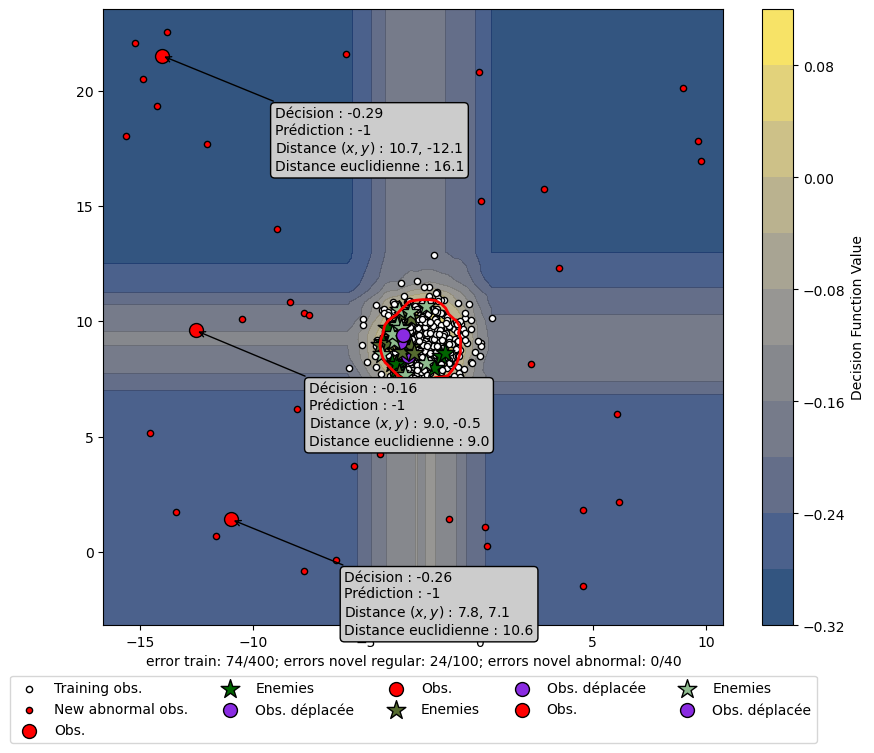

In [83]:
iso_forest_clf = train_isolation_forest(X_train)
y_pred = iso_forest_clf.predict(X_test)
y_pred_outliers = iso_forest_clf.predict(X_outliers)

# idx = [7, 16, 20]  # np.random.randint(X_outliers.shape[0])
# obs = X_outliers[idx]

fig, ax = plt.subplots(figsize=(10, 8))
visualize(X_train, X_test, X_outliers, iso_forest_clf, [X_outliers[7], X_outliers[20], far_obs], ax=ax)
print("predictions :", y_pred_outliers[7], y_pred_outliers[20], y_pred_outliers[16])

Même remarque concernant les forêts d'isolation, exemple très graphique également.

Ici, on voit que, pour deux exceptions situées à une distance similaires (9 et 10), elles peuvent avoir deux valeurs de décisions complétement différentes (-0.16 vs -0.26). La prédiction reste bonne, comme précédemment.


### <a id='toc1_3_2_'></a>[Importance d'attribut](#toc0_)

p. 25-26 du cours : [LookOut](https://github.com/xuhongzuo/outlier-interpretation), [DIFFI](https://github.com/mattiacarletti/DIFFI), [KernelSHAP](https://github.com/ronniemi/explainAnomaliesUsingSHAP)...

Nous avons décidé d'experimenter l'importance d'attribut avec DIFFI.


<Axes: xlabel='error train: 264/799; errors novel regular: 69/200; errors novel abnormal: 0/50'>

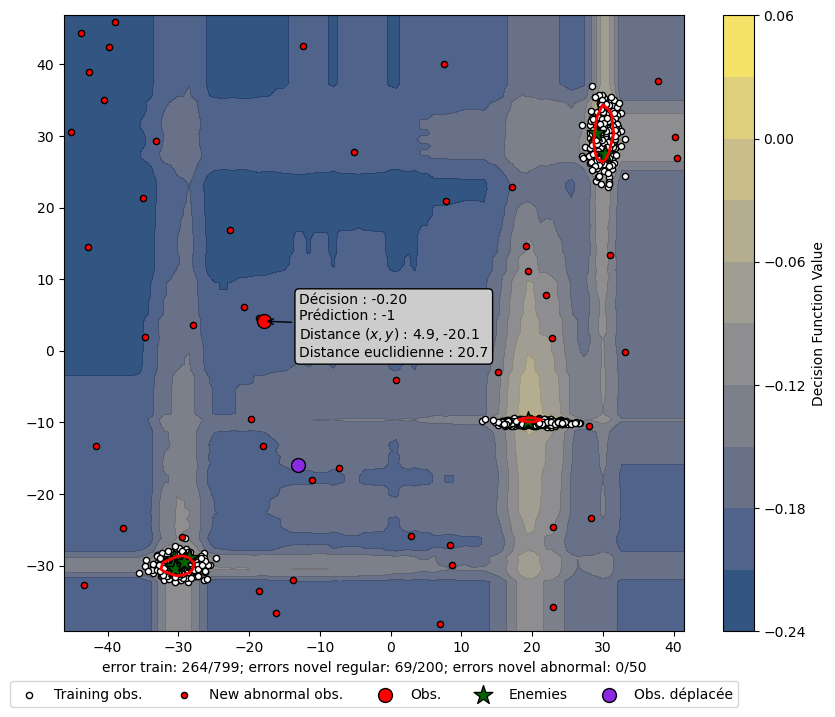

In [86]:
centers = [(-30, -30), (20, -10), (30, 30)]
cov = [
    np.array([[3, 0], [0, 1]]),
    np.array([[7, 0], [0, 0.05]]),
    np.array([[1, 0], [0, 7]]),
]
X_train, X_test, X_outliers = generate_elongated(n_clusters=3, centers=centers, cov=cov)

iso_forest_clf = train_isolation_forest(X_train, max_samples=256)
y_pred = iso_forest_clf.predict(X_test)

idx = np.random.randint(X_outliers.shape[0])
obs = X_outliers[idx]

fig, ax = plt.subplots(figsize=(10, 8))
visualize(X_train, X_test, X_outliers, iso_forest_clf, [obs], ax=ax)

Average computational time Local-DIFFI: 0.031


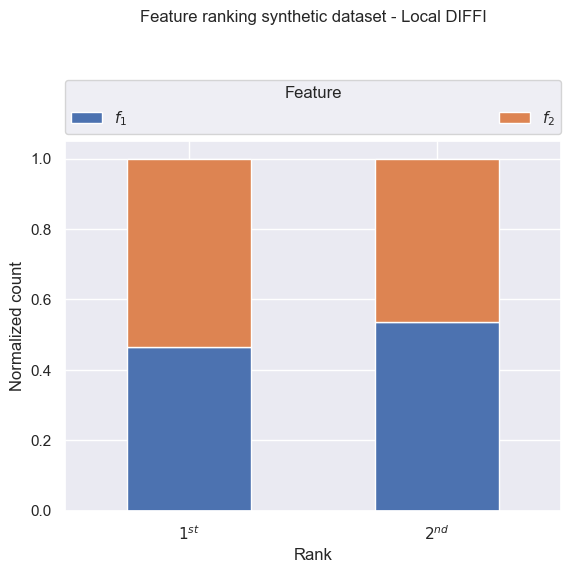

In [87]:
import interpretability_module as interp
from utils import *


def plot_ranking(ord_idx, title):
    sns.set(style="darkgrid")
    id2feat = {
        0: r"$f_1$",
        1: r"$f_2$",
        2: r"$f_3$",
        3: r"$f_4$",
        4: r"$f_5$",
        5: r"$f_6$",
    }
    x_ticks = [r"$1^{st}$", r"$2^{nd}$"]
    num_feats = ord_idx.shape[1]
    features = np.arange(num_feats)
    ranks = np.arange(1, num_feats + 1)
    rank_features = {
        r: [list(ord_idx[:, r - 1]).count(f) for f in features] for r in ranks
    }
    df = pd.DataFrame(rank_features)
    df_norm = df.transform(lambda x: x / sum(x))
    df_norm["Feature ID"] = features
    df_norm["Feature"] = df_norm["Feature ID"].map(id2feat)
    sns.set(style="darkgrid")
    df_norm.drop(["Feature ID"], inplace=True, axis=1)
    df_norm.set_index("Feature").T.plot(kind="bar", stacked=True)
    locs, labels = plt.xticks()
    plt.ylim((0, 1.05))
    plt.xticks(locs, x_ticks, rotation=0)
    plt.legend(
        bbox_to_anchor=(0.0, 1.02, 1.0, 0.102),
        loc="lower left",
        title="Feature",
        ncol=6,
        mode="expand",
        borderaxespad=0.0,
    )
    plt.xlabel("Rank")
    plt.ylabel("Normalized count")
    plt.title(title, y=1.3)


# Local-DIFFI
diffi_te, ord_idx_diffi_te, exec_time_diffi_te = local_diffi_batch(
    iso_forest_clf, X_test[y_pred == 1]
)
plot_ranking(
    ord_idx_diffi_te,
    title="Feature ranking synthetic dataset - Local DIFFI",
)
print(
    "Average computational time Local-DIFFI: {}".format(
        round(np.mean(exec_time_diffi_te), 3)
    )
)

Visiblement $x$ n'est pas plus important qu'$y$ (horizontal / vertical = déplacement sur la grille) : il faut souvent que l'outlier se déplace en diagonale. Enfin, il faudrait prendre le temps (que je n'ai pas) de lire un papier de 32 pages, sachant qu'un TME compte pour moins de 20 % (0.2 / nombre de TMEs rendus pris en compte) de la note finale (et avec un peu de chance ce TME ne sera même pas pris en compte).


Avec un dataset "classique" : Glass Identification (https://archive.ics.uci.edu/dataset/42/glass+identification)



F1 score (on training data): 0.556
Detected anomalies (test, class 7): 28 out of 29
Average computational time Local-DIFFI: 0.023


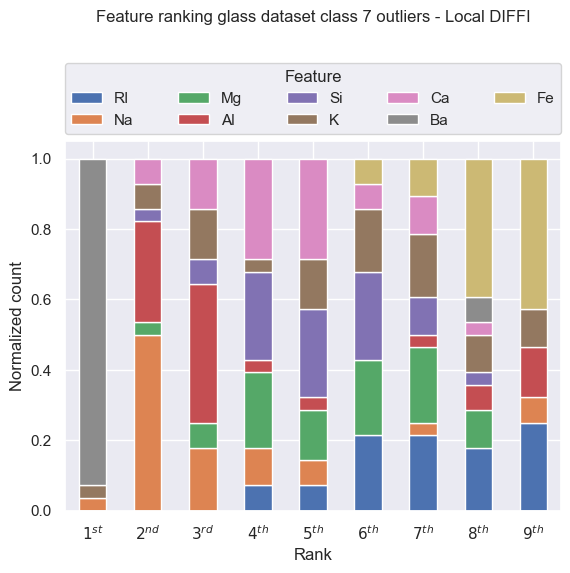

In [88]:
import pickle as pkl


with open(os.path.join(os.getcwd(), "data", "local", "glass.pkl"), "rb") as f:
    data = pkl.load(f)

# training data (inliers and outliers)
X_tr = np.concatenate((data["X_in"], data["X_out_5"], data["X_out_6"]))
y_tr = np.concatenate((data["y_in"], data["y_out_5"], data["y_out_6"]))
X_tr, y_tr = shuffle(X_tr, y_tr, random_state=0)
# test outliers
X_te = data["X_out_7"]
y_te = data["y_out_7"]

iforest = IsolationForest(
    n_estimators=100,
    max_samples=64,
    contamination="auto",
    random_state=0,
    bootstrap=False,
)
iforest.fit(X_tr)
y_tr_pred = np.array(iforest.decision_function(X_tr) < 0).astype("int")
f1 = f1_score(y_tr, y_tr_pred)
print("\nF1 score (on training data): {}".format(round(f1, 3)))

y_te_pred = np.array(iforest.decision_function(X_te) < 0).astype("int")
print(
    "Detected anomalies (test, class 7): {} out of {}".format(
        int(sum(y_te_pred)), len(y_te)
    )
)

# Local-DIFFI
diffi_te, ord_idx_diffi_te, exec_time_diffi_te = local_diffi_batch(
    iforest, X_te[np.where(y_te_pred == 1)]
)
plot_ranking_glass(
    ord_idx_diffi_te,
    title="Feature ranking glass dataset class 7 outliers - Local DIFFI",
)
print(
    "Average computational time Local-DIFFI: {}".format(
        round(np.mean(exec_time_diffi_te), 3)
    )
)

Pratique quand on a des données plus complexes. Cette figure fournit une visualisation globale de l'importance relative des différentes caractéristiques dans la détection d'anomalies. Des caractéristiques qui apparaissent fréquemment dans les premiers rangs peuvent être considérées comme des indicateurs clés des anomalies dans le dataset, tandis que celles qui sont souvent classées plus bas peuvent avoir un impact moindre sur la décision du modèle.


LIME ? Non, les classifieurs ne sont pas compatibles avec LIME (ou l'inverse ?) : besoin des scores de probabilité, avec `predict_proba`, que nous n'avons pas.


## <a id='toc1_4_'></a>[Explications moins naïves](#toc0_)


Ce n'est plus un TME à ce stade, c'est un projet...

Grégory Smits, Marie-Jeanne Lesot, Véronne Yepmo, Olivier Pivert. [PANDA : Personnaliser les ANomalies Détectées par Apprentissage](https://inria.hal.science/hal-03777547). LFA 2022 - Rencontres francophones sur la logique floue et ses applications, Oct 2022, Toulouse, France. ⟨hal-03777547⟩ 

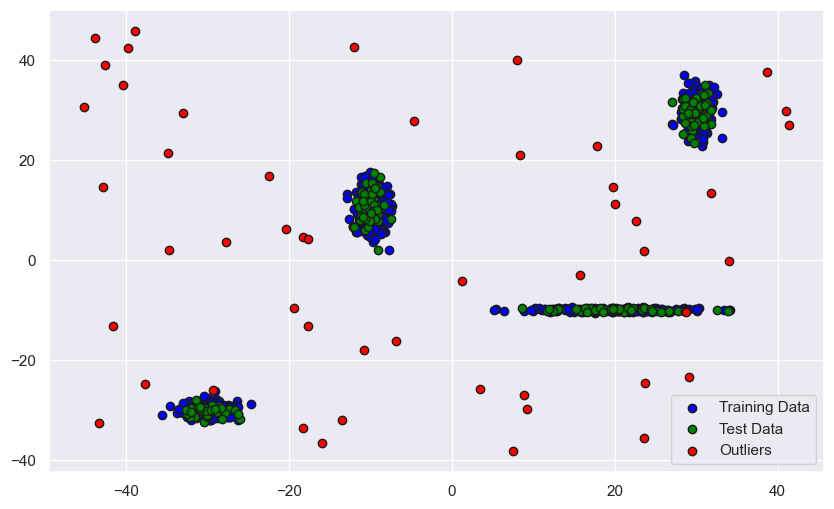

In [89]:
import skfuzzy as fuzz


class PANDA:
    def __init__(
        self, x_universe, y_universe, x_modalities, y_modalities, clf=IsolationForest()
    ):
        self.x_universe = x_universe
        self.y_universe = y_universe
        self.x_modalities = x_modalities
        self.y_modalities = y_modalities
        self.clf = clf

    def calculate_memberships(self, point):
        x_membership = {
            label: fuzz.interp_membership(self.x_universe, mf, point[0])
            for label, mf in self.x_modalities.items()
        }
        y_membership = {
            label: fuzz.interp_membership(self.y_universe, mf, point[1])
            for label, mf in self.y_modalities.items()
        }
        return np.array(list(x_membership.values()) + list(y_membership.values()))

    def transform_data(self, X):
        # Transform the data using the fuzzy partitions
        return np.array([self.calculate_memberships(point) for point in X])

    def fit(self, X):
        # Transform the data
        transformed_X = self.transform_data(X)
        # Fit the classifier on the transformed data
        self.clf.fit(transformed_X)

    def predict(self, X):
        # Transform the data
        transformed_X = self.transform_data(X)
        # Make predictions in the transformed space
        return self.clf.predict(transformed_X)

    def decision_function(self, X):
        # Transform the data
        transformed_X = self.transform_data(X)
        # Compute the decision function in the transformed space
        return self.clf.decision_function(transformed_X)


# Usage
centers = [(-30, -30), (20, -10), (-10, 10), (30, 30)]
cov = [
    np.array([[3, 0], [0, 1]]),
    np.array([[30, 0], [0, 0.05]]),
    np.array([[1, 0], [0, 10]]),
    np.array([[1, 0], [0, 7]]),
]
X_train, X_test, X_outliers = generate_elongated(n_clusters=4, centers=centers, cov=cov)
plot_data(X_train, X_test, X_outliers)

Ici, le plus important est de bien comprendre la structure des données (notion de vocabulaire _flou_ disponible de l'utilisateur, il y a un à priori sur la connaissances des données).


In [90]:
# Define the universes of discourse
x_universe = np.linspace(-50, 50, 1000)
y_universe = np.linspace(-50, 50, 1000)

# Define modalities for x and y
x_modalities = {
    "anormalemement faible": fuzz.trapmf(x_universe, [-50, -50, -40, -35]),
    "faible": fuzz.trapmf(x_universe, [-40, -35, -25, -20]),
    "moyenne": fuzz.trapmf(x_universe, [-20, -15, -5, 0]),
    "élevée": fuzz.trapmf(x_universe, [-5, 5, 25, 30]),
    "trop élevée": fuzz.trapmf(x_universe, [30, 35, 50, 50]),
}
y_modalities = {
    "faible": fuzz.trapmf(y_universe, [-45, -40, -30, -25]),
    "moyenne": fuzz.trapmf(y_universe, [-30, -20, 0, 5]),
    "élevée": fuzz.trapmf(y_universe, [0, 5, 20, 25]),
    "trop élevée": fuzz.trapmf(y_universe, [20, 30, 50, 50]),
}

panda = PANDA(x_universe, y_universe, x_modalities, y_modalities)
panda.fit(X_train)
predictions = panda.predict(X_outliers)
(predictions == -1).sum() / len(X_outliers)

0.74

<Axes: title={'center': 'PANDA Decision Boundary'}>

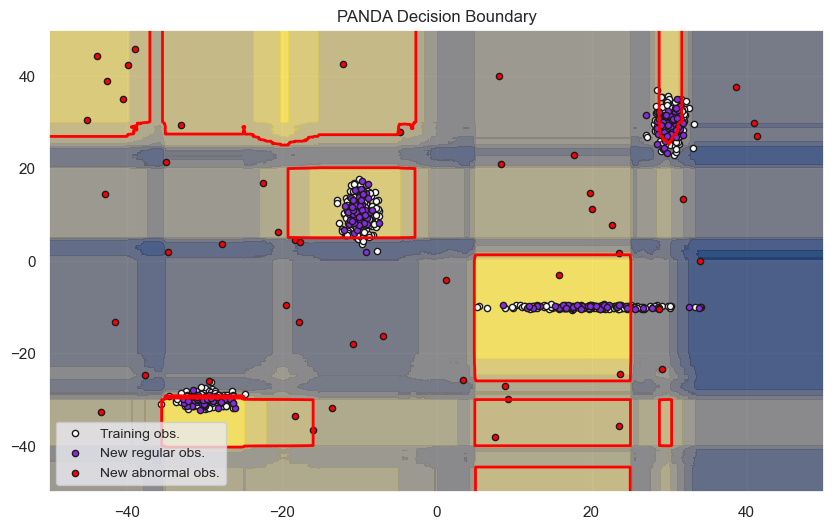

In [91]:
def plot_decision_boundary_panda(
    panda, X_train, X_test, X_outliers, ax=None, title=None
):
    if not ax:
        fig, ax = plt.subplots(figsize=(10, 6))

    # Create grid to plot decision boundaries
    x_min, x_max = min(panda.x_universe), max(panda.x_universe)
    y_min, y_max = min(panda.y_universe), max(panda.y_universe)
    xx, yy = np.meshgrid(panda.x_universe, panda.y_universe)
    mesh_samples = np.c_[xx.ravel(), yy.ravel()]

    # Plot decision boundary
    Z = panda.decision_function(mesh_samples)
    Z = Z.reshape(xx.shape)
    contour = ax.contourf(xx, yy, Z, levels=10, cmap=plt.cm.cividis, alpha=0.8)
    ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors="red")

    # Plot training points
    ax.scatter(
        X_train[:, 0],
        X_train[:, 1],
        c="white",
        edgecolor="k",
        s=20,
        label="Training obs.",
    )

    # Plot test points
    ax.scatter(
        X_test[:, 0],
        X_test[:, 1],
        c="blueviolet",
        edgecolor="k",
        s=20,
        label="New regular obs.",
    )
    # Plot outliers
    ax.scatter(
        X_outliers[:, 0],
        X_outliers[:, 1],
        c="red",
        edgecolor="k",
        s=20,
        label="New abnormal obs.",
    )

    if title:
        ax.set_title(title)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.legend(fontsize="small")

    return ax


plot_decision_boundary_panda(
    panda, X_train, X_test, X_outliers, title="PANDA Decision Boundary"
)

It works (mais temps de calcul assez long (à cause de la transformation)) ! Maintenant, ce serait cool d'avoir une sortie plus proche du cours / papier (qui affiche les fuzzy sets) :


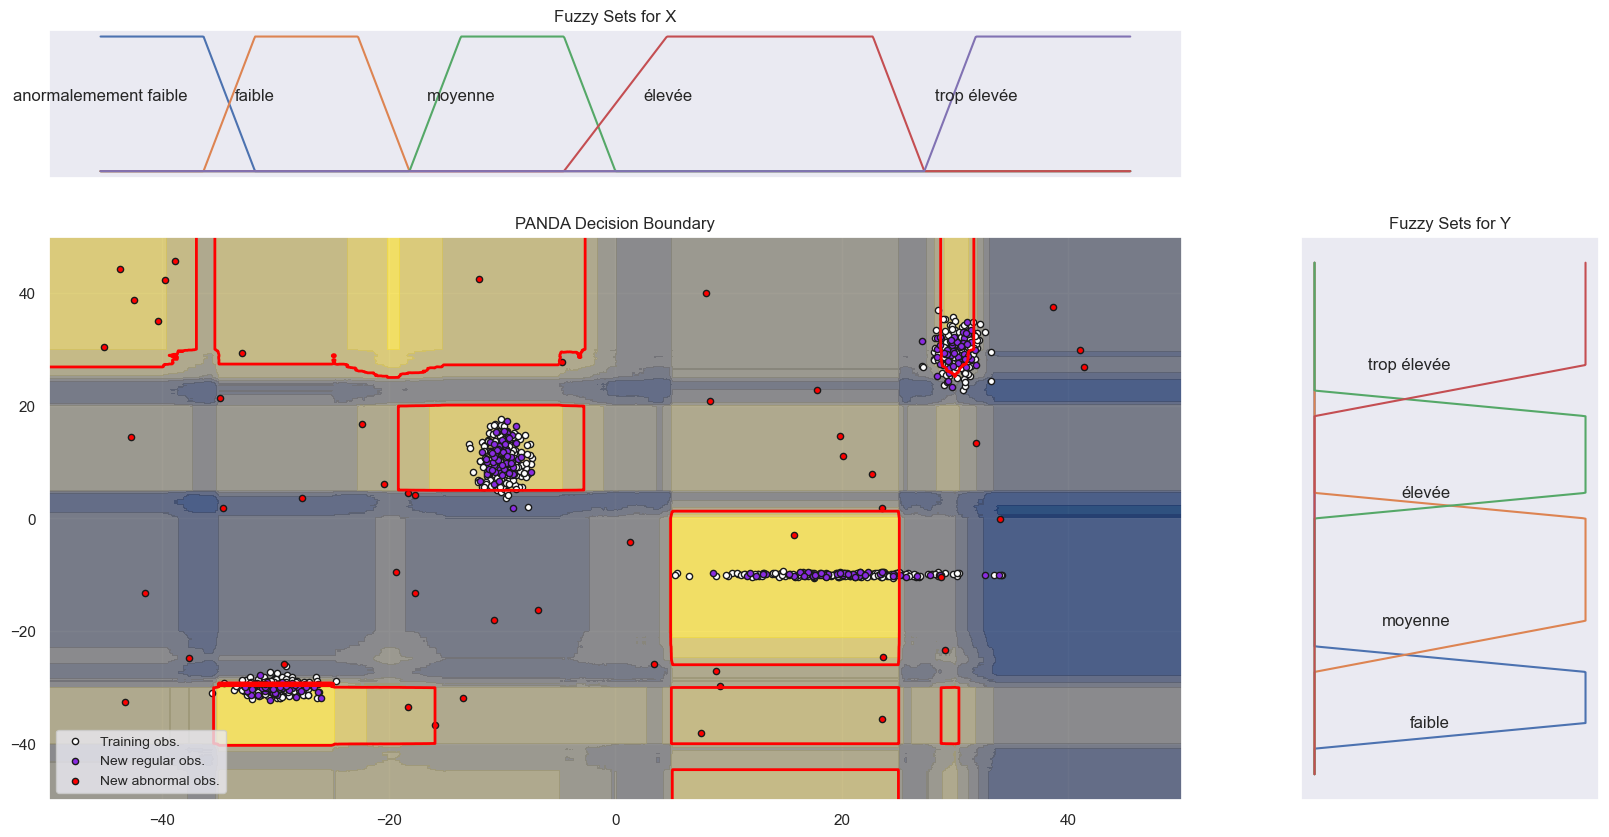

In [92]:
import matplotlib.gridspec as gridspec


def plot_fuzzy_partitions(x_modalities, y_modalities, x_universe, y_universe):
    # Create a figure with GridSpec layout
    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(4, 4, figure=fig, hspace=0.4, wspace=0.4)

    # Main scatter plot
    ax_main = fig.add_subplot(gs[1:4, 0:3])

    # Subplot for x-universe fuzzy sets below the main plot
    ax_x = fig.add_subplot(gs[0, 0:3])

    # Subplot for y-universe fuzzy sets to the left of the main plot
    ax_y = fig.add_subplot(gs[1:4, 3])

    # Plot fuzzy sets for x_universe
    for label, mf in x_modalities.items():
        ax_x.plot(x_universe, mf, label=label)
        idx = np.argmax(mf)
        ax_x.text(x_universe[idx], 0.5, label, ha="center", va="bottom")
    ax_x.set_title("Fuzzy Sets for X")

    # Plot fuzzy sets for y_universe
    for label, mf in y_modalities.items():
        ax_y.plot(mf, y_universe, label=label)  # Note the reversed order for x and y
        idx = np.argmax(mf)
        ax_y.text(0.5, y_universe[idx], label, ha="right", va="center")
    ax_y.set_title("Fuzzy Sets for Y")

    # Adjust the layout and disable axis labels for the fuzzy partitions (optional)
    ax_x.grid(False)
    ax_x.xaxis.set_visible(False)
    ax_x.yaxis.set_visible(False)
    ax_y.grid(False)
    ax_y.xaxis.set_visible(False)
    ax_y.yaxis.set_visible(False)

    # Customize the main plot as needed
    ax_main.set_title("PANDA Decision Boundary")

    plot_decision_boundary_panda(panda, X_train, X_test, X_outliers, ax=ax_main)
    plt.close()
    return fig


plot_fuzzy_partitions(x_modalities, y_modalities, x_universe, y_universe)

Le plus compliqué : **choisir un vocabulaire adéquat**.
